In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import copy
import math
from torchvision import models
class Net_cifar100_s(nn.Module):
    def __init__(self):
        super(Net_cifar100_s, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 100)
        # self.fc3 = nn.Linear(84, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        return x
mycfg = {
    'CNN3':  [64, 'M', 64, 'M', 128, 'M', 512, 'M'],
    'CNN4':  [64, 'M', 128, 'M', 128, 'M', 512, 'M'],
    'CNN5':  [64, 'M', 128, 'M', 256, 'M', 512, 'M'],
    'CNN6':  [64, 'M', 128, 'M', 512, 'M', 512, 'M'],
    'CNN7':  [64, 'M', 256, 'M', 512, 'M', 512, 'M'], ### targetmodel
    'CNN8':  [64, 'M', 128, 256, 'M', 512, 'M', 512, 'M'],
    'CNN9':  [64, 64, 'M', 128, 256, 'M', 512, 'M', 512, 'M'],
    'CNN10':  [64, 128, 'M', 128, 256, 'M', 512, 'M', 512, 'M'],
    'CNN11':  [64, 128, 'M', 256, 256, 'M', 512, 'M', 512, 'M'],
}
class Net_cifar100_m(nn.Module):
    def __init__(self, CNN_name='CNN7', dropout=False):
        super(Net_cifar100_m, self).__init__()
        self.query_num = 0
        self.features = self._make_layers(mycfg[CNN_name])
        if dropout:
            self.classifier = nn.Sequential(
                nn.Dropout(0.6),
                nn.Linear(512, 256),
                nn.ReLU(True),
                nn.Linear(256, 100) )
        else:
            self.classifier = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(True),
                nn.Linear(256, 100) )
        
    def forward(self, x):
        self.query_num += 1
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x, track_running_stats=True),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=2, stride=2)]
        return nn.Sequential(*layers)

class Net_mnist(nn.Module):
    def __init__(self):
        super(Net_mnist, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
class Net_cifar10(nn.Module):
    def __init__(self):
        super(Net_cifar10, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
class Arguments:
    def __init__(self, dataset_name):
        self.N_client_max = 5
        self.N_client = 5
        self.data_name = 'cifar100' if dataset_name == 'cifar100' else 'MNIST' if dataset_name == 'mnist' else 'cifar10'
        self.global_epoch = 10 if dataset_name == 'cifar100' else 10 if dataset_name == 'mnist' else 10
        self.local_epoch = 10 if dataset_name == 'cifar100' else 5 if dataset_name == 'mnist' else 5
        self.save_all_models = False
        self.local_lr = 0.001 if dataset_name == 'cifar100' else 0.01 if dataset_name == 'mnist' else 0.001
        self.train_with_test = False
        self.use_gpu = True
        self.target_client = np.random.randint(0, self.N_client)
        self.cuda_state = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.device_cpu = torch.device('cpu')
        self.image_shape = (3,32,32) if dataset_name == 'cifar100' else (1,28,28) if dataset_name == 'mnist' else (3,32,32)
        self.class_num = 100 if dataset_name == 'cifar100' else 10 if dataset_name == 'mnist' else 10
        self.adv_iter = 60
        self.adv_lr = 0.3 if dataset_name == 'cifar100' else 0.3 if dataset_name == 'mnist' else 0.3
        self.decay_lr = 1
        self.num_evals_boundary = 5000
        self.beta_init = 0
        self.beta_step_size = 0.1
        self.beta_max = 2
        self.adv_with_test = True
        self.sample_num = 1000
        self.radius_num = 5
        self.noise_radnum = 100
        self.clear_num = 1036 if dataset_name == 'cifar100' else 2096 if dataset_name == 'mnist' else 1411
         # for tear
        self.target_num = 10

def data_params(dataset_name):
    if dataset_name == 'cifar100':
        FL_params = Arguments(dataset_name)
    #     resnet = models.resnet18(pretrained=True)
    #     resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(3,3), stride=(2,2), padding=(3, 3), bias=False)
    #     init_GM = resnet  #training acc: 0.73     test acc: 0.43    drawback: hsja is very slow
    #     init_GM = Net_cifar100_s()   #training acc: 0.3801           test acc: 0.2089    drawback: tgt_list doesn't have all the classes
        init_GM = Net_cifar100_m()
    elif dataset_name == 'mnist':
        FL_params = Arguments(dataset_name)
        init_GM = Net_mnist()
    elif dataset_name == 'cifar10':
        FL_params = Arguments(dataset_name)
        init_GM = Net_cifar10()
    else:
        raise ValueError('Please input a correct dataset name')
    return FL_params, init_GM
import os
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
def validation_metrics(memberset, nonmemberset, mode='XGB', params=None):
    '''
    memberset和nonmemberset都是已经已训练得到的成员性质；
    该函数：1.把memeberset和nonmemberset分为trainset和testset，两个set都含有member和non_member,
              其中testset中含有等比例的member和non_member，non_member中含有一部分预测错误的样本
            2.输出为balanced_accuracy, precision, recall, F1-score
    '''
    y_mem = np.ones(memberset.shape[0])
    y_nonmem = np.zeros(nonmemberset.shape[0])
    X_train_mem, X_test_mem, y_train_mem, y_test_mem = train_test_split(memberset, y_mem, test_size=0.1, random_state=39)
    X_train_nonmem, X_test_nonmem, y_train_nonmem, y_test_nonmem = train_test_split(nonmemberset, y_nonmem, test_size=0.1, random_state=39)
    X_train = np.vstack([X_train_mem, X_train_nonmem])
    X_test = np.vstack([X_test_mem, X_test_nonmem])
    y_train = np.hstack([y_train_mem, y_train_nonmem])
    y_test = np.hstack([y_test_mem, y_test_nonmem])
    # print(y_test.shape)   200
    y_pred_train = np.zeros(len(y_train))
    y_pred_test = np.zeros(len(y_test))
    random_state = random.randint(0, 200)

    if mode == 'XGB':
        if params is None:
            # params = {
            # 'max_depth' : 7,
            # 'min_child_weight' : 4,
            # 'scale_pos_weight' : 5,
            # 'learning_rate' : 0.1,
            # 'n_estimators' : 80,
            # 'gamma' : 0,
            # 'subsample' : 0.8,
            # 'colsample_bytree' : 0.8,
            # 'objective' : 'binary:logistic',
            # }
            
            params_test1 = {
            'max_depth' : [5,7],
            'min_child_weight' : [3,4]
            }
            classifier = XGBClassifier(learning_rate=0.1, n_estimators=80, scale_pos_weight=5,  gamma=None,
                                       subsample=None, colsample_bytree=None, objective='binary:logistic', random_state=3407)
            classifier = GridSearchCV(classifier, param_grid=params_test1, n_jobs=-1, scoring='f1', cv=5)
            classifier.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
            print("the best params are: ", classifier.best_params_)
            print("the best (f1) score is: ", classifier.best_score_)
            print()
            classifier = classifier.best_estimator_
        else:
            classifier = XGBClassifier(learning_rate=params['learning_rate'], 
                                       n_estimators=params['n_estimators'],
                                        max_depth=params['max_depth'],
                                          min_child_weight=params['min_child_weight'],
                                            scale_pos_weight=params['scale_pos_weight'],
                                            gamma=params['gamma'],
                                            subsample=params['subsample'],
                                            colsample_bytree=params['colsample_bytree'],
                                            objective=params['objective'],
                                            random_state=params['random_state'],
                                            reg_alpha=params['reg_alpha'],
                                            reg_lambda=params['reg_lambda'])
                                            
            classifier.fit(X_train, y_train, verbose=False)
        p_train = classifier.predict(X_train)
        p_test = classifier.predict(X_test)
   
    print("Distance record: acc_train:{}, banlanced_acc_test:{}, precision:{}, recall:{}, f1_score:{}".
          format(accuracy_score(y_train, p_train), accuracy_score(y_test, p_test),
                  precision_score(y_test, p_test, pos_label=1),
                  recall_score(y_test, p_test, pos_label=1),
                  f1_score(y_test, p_test, pos_label=1)))
    return p_train, p_test, y_train, y_test

E:\syn_anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 调参细则
第一步：确定学习速率'learning_rate'和参数调优的估计器数目'n_estimators'。  学习率从0.1开始，然后再调估计器的数目

第二步：max_depth（默认6） 和 min_child_weight（默认1），scale_pos_weight参数(默认1)调优。先大范围搜索，max_depth：range(3,10,2)   min_child_weight：range(1,6,2)  再小范围搜索

第三步：gamma参数（默认0）调优。大范围搜索，'gamma':[i/10.0 for i in range(0,20)]    再小范围搜索

第四步：调整subsample（默认1） 和 colsample_bytree 参数（默认1）。搜索：'subsample':[i/10.0 for i in range(6,10)], 'colsample_bytree':[i/10.0 for i in range(6,10)]
之后可以以0.05的步长进行取值

第五步：正则化参数调优。'reg_alpha'（L1,默认0）:[1e-5, 1e-2, 0.1, 1, 100]   'reg_lambda'（L2,默认1）:[1e-5, 1e-2, 0.1, 1, 100]  (通常没用)

第六步：我们使用较低的学习速率，以及使用更多的决策树

## 不同轮次的评估

In [31]:
iters = 5
dataset_name = 'cifar100'
FL_params, init_GM = data_params(dataset_name)
# pro_distances_norm_mem = torch.load('F:/data_tear/' + str(FL_params.data_name) + '/ablation/model/{}/pro_distances_norm_mem.pth'.format(iters))
# pro_distances_norm_nonmem = torch.load('F:/data_tear/' + str(FL_params.data_name) + '/ablation/model/{}/pro_distances_norm_nonmem.pth'.format(iters))
pro_distances_norm_mem = torch.load('E:/postgraduate/paper/TEAR/dbViz-main/tear_come/data/' + str(FL_params.data_name) + '/pro_distances_norm_mem.pth')
pro_distances_norm_nonmem = torch.load('E:/postgraduate/paper/TEAR/dbViz-main/tear_come/data/' + str(FL_params.data_name) + '/pro_distances_norm_nonmem.pth')
params = {
            'max_depth' : 8,             #12    11       4     11
            'min_child_weight' : 1,       #2      1      4      2
            'scale_pos_weight' : 4,       #3      2      3      2
            'learning_rate' : 0.1,      #0.09    0.1    0.12    0.1
            'n_estimators' : 48,         #47     19     105     70
            'gamma' : 0.01,
            'subsample' : 1.0,
            'colsample_bytree' : 1.0,
            'objective' : 'binary:logistic',
            'random_state' : 3407,
            'reg_alpha' : 0.0,
            'reg_lambda' : 1.0
            }


learning_rate = [0.1]
n_estimators = range(45,50)
for lr in learning_rate:
    for n_est in n_estimators:
        params['learning_rate'] = lr
        params['n_estimators'] = n_est
        print('learning_rate:', lr, 'n_estimators:', n_est) 
        p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)
          

# max_depth: 8, min_child_weight: 1, scale_pos_weight: 4  0.1  48
# Distance record: acc_train:0.9994444444444445, banlanced_acc_test:0.615, precision:0.5804195804195804, recall:0.83, f1_score:0.6831275720164608
# 0.09  25-45 0.091 15-25,35-45 
# p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)
# mnist:
# 1: acc_train:0.9172222222222223, banlanced_acc_test:0.585, precision:0.5502958579881657, recall:0.93, f1_score:0.6914498141263941
# 5: acc_train:0.9983333333333333, banlanced_acc_test:0.575, precision:0.5483870967741935, recall:0.85, f1_score:0.6666666666666665

# cifar10:
# 1: acc_train:0.6905555555555556, banlanced_acc_test:0.56, precision:0.5337078651685393, recall:0.95, f1_score:0.6834532374100718
# 5: acc_train:0.8616666666666667, banlanced_acc_test:0.595, precision:0.5612903225806452, recall:0.87, f1_score:0.6823529411764706


learning_rate: 0.1 n_estimators: 45
Distance record: acc_train:0.9994444444444445, banlanced_acc_test:0.57, precision:0.5466666666666666, recall:0.82, f1_score:0.6559999999999999
learning_rate: 0.1 n_estimators: 46
Distance record: acc_train:1.0, banlanced_acc_test:0.585, precision:0.5586206896551724, recall:0.81, f1_score:0.6612244897959184
learning_rate: 0.1 n_estimators: 47
Distance record: acc_train:1.0, banlanced_acc_test:0.575, precision:0.5517241379310345, recall:0.8, f1_score:0.6530612244897959
learning_rate: 0.1 n_estimators: 48
Distance record: acc_train:1.0, banlanced_acc_test:0.575, precision:0.5510204081632653, recall:0.81, f1_score:0.6558704453441295
learning_rate: 0.1 n_estimators: 49
Distance record: acc_train:1.0, banlanced_acc_test:0.575, precision:0.5503355704697986, recall:0.82, f1_score:0.6586345381526104


## 噪声组数量的评估

### mnist

In [75]:
dataset_name = 'mnist'
FL_params, init_GM = data_params(dataset_name)
pro_distances_mem = torch.load('E:/postgraduate/paper/TEAR/dbViz-main/tear_come/data/' + str(FL_params.data_name) + '/pro_distances_mem.pth').cuda()
pro_distances_nonmem = torch.load('E:/postgraduate/paper/TEAR/dbViz-main/tear_come/data/' + str(FL_params.data_name) + '/pro_distances_nonmem.pth').cuda()
print(pro_distances_mem.shape, pro_distances_nonmem.shape)
radius_num = 5
# pro_distances_memv = pro_distances_mem[:,(FL_params.radius_num-radius_num)*FL_params.noise_radnum:]  #(sample_num, radius_num*noise_radnum)
# pro_distances_nonmemv = pro_distances_nonmem[:,(FL_params.radius_num-radius_num)*FL_params.noise_radnum:]  #(sample_num, radius_num*noise_radnum)
# pro_distances_norm_mem = pro_distances_memv / torch.norm(pro_distances_memv, p=2, dim=1).unsqueeze(1)
# pro_distances_norm_nonmem = pro_distances_nonmemv / torch.norm(pro_distances_nonmemv, p=2, dim=1).unsqueeze(1)
# pro_distances_norm_mem = torch.cat([pro_distances_norm_mem, torch.norm(pro_distances_memv, p=2, dim=1).unsqueeze(1)], dim=1).cpu()
# pro_distances_norm_nonmem = torch.cat([pro_distances_norm_nonmem, torch.norm(pro_distances_nonmemv, p=2, dim=1).unsqueeze(1)], dim=1).cpu()
# print(pro_distances_norm_mem.shape, pro_distances_norm_nonmem.shape)  #(sample_num, radius_num*noise_radnum+1)
pro_distances_norm_mem = pro_distances_mem[:,(FL_params.radius_num-radius_num)*FL_params.noise_radnum:].cpu()
pro_distances_norm_nonmem = pro_distances_nonmem[:,(FL_params.radius_num-radius_num)*FL_params.noise_radnum:].cpu()
print(pro_distances_norm_mem.shape, pro_distances_norm_nonmem.shape)  #(sample_num, radius_num*noise_radnum+1)

params = {
            'max_depth' : 5,          #6
            'min_child_weight' : 3,   #4
            'scale_pos_weight' : 4,   #4
            'learning_rate' : 0.1,    #0.1
            'n_estimators' : 80,     #106
            'gamma' : 0.0,
            'subsample' : 1.0,
            'colsample_bytree' : 1.0,
            'objective' : 'binary:logistic',
            'random_state' : 3407,
            'reg_alpha' : 0.0,
            'reg_lambda' : 1.0
            }
# n_estimators = range(10,100,10)
# n_estimators = range(70,100)
# for n_est in n_estimators:
#     params['n_estimators'] = n_est
#     print('n_estimators:', n_est)
#     p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)

# max_depth = range(5,16)
# min_child_weight = range(1,6)
# scale_pos_weight = range(1,6)
# for md in max_depth:
#     for mcw in min_child_weight:
#         for spw in scale_pos_weight:
#             params['max_depth'] = md
#             params['min_child_weight'] = mcw
#             params['scale_pos_weight'] = spw
#             print('max_depth:', md, 'min_child_weight:', mcw, 'scale_pos_weight:', spw)
#             p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)
# learning_rate = [0.106]
# n_estimators = range(60,100)
learning_rate = [0.095,0.096,0.097,0.098,0.099,0.1,0.101,0.102,0.103,0.104,0.105]
n_estimators = range(10,100,10)
for lr in learning_rate:
    for n_est in n_estimators:
        params['learning_rate'] = lr
        params['n_estimators'] = n_est
        print('learning_rate:', lr, 'n_estimators:', n_est) 
        p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)

# p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)
# mnist:
# 1:  11 1 2
# learning_rate: 0.099 n_estimators: 11
# Distance record: acc_train:0.8172222222222222, banlanced_acc_test:0.55, precision:0.5271739130434783, recall:0.97, f1_score:0.6830985915492959
# learning_rate: 0.1 n_estimators: 17   
# Distance record: acc_train:0.9138888888888889, banlanced_acc_test:0.555, precision:0.5325443786982249, recall:0.9, f1_score:0.6691449814126396
# learning_rate: 0.098 n_estimators: 30  
# Distance record: acc_train:0.9888888888888889, banlanced_acc_test:0.56, precision:0.538961038961039, recall:0.83, f1_score:0.6535433070866141
# 0.103 10-30  0.101 10-20  0.1  10-30  0.099 10-40  0.098 20-60  0.097 10-20

# 2:
# 8 1 2: 
# learning_rate: 0.1 n_estimators: 21
# Distance record: acc_train:0.8138888888888889, banlanced_acc_test:0.55, precision:0.5277777777777778, recall:0.95, f1_score:0.6785714285714285
# learning_rate: 0.1 n_estimators: 43
# Distance record: acc_train:0.9811111111111112, banlanced_acc_test:0.555, precision:0.535031847133758, recall:0.84, f1_score:0.6536964980544747

# 3: 
# 5 4 2
# learning_rate: 0.1 n_estimators: 33
# Distance record: acc_train:0.6716666666666666, banlanced_acc_test:0.555, precision:0.5300546448087432, recall:0.97, f1_score:0.685512367491166
# 8 5 1 
# learning_rate: 0.1 n_estimators: 40
# Distance record: acc_train:0.9783333333333334, banlanced_acc_test:0.585, precision:0.5779816513761468, recall:0.63, f1_score:0.6028708133971291
# learning_rate: 0.098 n_estimators: 22
# Distance record: acc_train:0.9416666666666667, banlanced_acc_test:0.6, precision:0.6086956521739131, recall:0.56, f1_score:0.5833333333333334
        
# 4
# learning_rate: 0.1 n_estimators: 67
# Distance record: acc_train:0.8861111111111111, banlanced_acc_test:0.585, precision:0.5508982035928144, recall:0.92, f1_score:0.6891385767790262

# 5
# 6 4 2
# learning_rate: 0.1 n_estimators: 42
# Distance record: acc_train:0.8144444444444444, banlanced_acc_test:0.575, precision:0.5423728813559322, recall:0.96, f1_score:0.6931407942238268
# 15 4 5
# learning_rate: 0.105 n_estimators: 76
# Distance record: acc_train:0.9977777777777778, banlanced_acc_test:0.58, precision:0.5459770114942529, recall:0.95, f1_score:0.6934306569343065

torch.Size([1000, 500]) torch.Size([1000, 500])
torch.Size([1000, 500]) torch.Size([1000, 500])
learning_rate: 0.095 n_estimators: 10
Distance record: acc_train:0.5011111111111111, banlanced_acc_test:0.505, precision:0.5025125628140703, recall:1.0, f1_score:0.6688963210702341
learning_rate: 0.095 n_estimators: 20
Distance record: acc_train:0.5205555555555555, banlanced_acc_test:0.505, precision:0.5025125628140703, recall:1.0, f1_score:0.6688963210702341
learning_rate: 0.095 n_estimators: 30
Distance record: acc_train:0.5594444444444444, banlanced_acc_test:0.51, precision:0.5050505050505051, recall:1.0, f1_score:0.6711409395973155
learning_rate: 0.095 n_estimators: 40
Distance record: acc_train:0.6011111111111112, banlanced_acc_test:0.515, precision:0.5076142131979695, recall:1.0, f1_score:0.6734006734006733
learning_rate: 0.095 n_estimators: 50
Distance record: acc_train:0.6444444444444445, banlanced_acc_test:0.51, precision:0.5051020408163265, recall:0.99, f1_score:0.6689189189189189


### cifar10

In [132]:
dataset_name = 'cifar10'
FL_params, init_GM = data_params(dataset_name)
pro_distances_mem = torch.load('E:/postgraduate/paper/TEAR/dbViz-main/tear_come/data/' + str(FL_params.data_name) + '/pro_distances_mem.pth').cuda()
pro_distances_nonmem = torch.load('E:/postgraduate/paper/TEAR/dbViz-main/tear_come/data/' + str(FL_params.data_name) + '/pro_distances_nonmem.pth').cuda()
print(pro_distances_mem.shape, pro_distances_nonmem.shape)
radius_num = 5
# pro_distances_memv = pro_distances_mem[:,(FL_params.radius_num-radius_num)*FL_params.noise_radnum:]  #(sample_num, radius_num*noise_radnum)
# pro_distances_nonmemv = pro_distances_nonmem[:,(FL_params.radius_num-radius_num)*FL_params.noise_radnum:]  #(sample_num, radius_num*noise_radnum)
# pro_distances_norm_mem = pro_distances_memv / torch.norm(pro_distances_memv, p=2, dim=1).unsqueeze(1)
# pro_distances_norm_nonmem = pro_distances_nonmemv / torch.norm(pro_distances_nonmemv, p=2, dim=1).unsqueeze(1)
# pro_distances_norm_mem = torch.cat([pro_distances_norm_mem, torch.norm(pro_distances_memv, p=2, dim=1).unsqueeze(1)], dim=1).cpu()
# pro_distances_norm_nonmem = torch.cat([pro_distances_norm_nonmem, torch.norm(pro_distances_nonmemv, p=2, dim=1).unsqueeze(1)], dim=1).cpu()
# print(pro_distances_norm_mem.shape, pro_distances_norm_nonmem.shape)  #(sample_num, radius_num*noise_radnum+1)
pro_distances_norm_mem = pro_distances_mem[:,(FL_params.radius_num-radius_num)*FL_params.noise_radnum:].cpu()
pro_distances_norm_nonmem = pro_distances_nonmem[:,(FL_params.radius_num-radius_num)*FL_params.noise_radnum:].cpu()
print(pro_distances_norm_mem.shape, pro_distances_norm_nonmem.shape)  #(sample_num, radius_num*noise_radnum+1)
# 7 3 3
params = {
            'max_depth' : 7,          #6
            'min_child_weight' : 4,   #4
            'scale_pos_weight' : 2,   #4
            'learning_rate' : 0.1,    #0.1
            'n_estimators' : 89,     #106
            'gamma' : 0.0,
            'subsample' : 1.0,
            'colsample_bytree' : 1.0,
            'objective' : 'binary:logistic',
            'random_state' : 3407,
            'reg_alpha' : 0.0,
            'reg_lambda' : 1.0
            }
# n_estimators = range(100,150)
# for n_est in n_estimators:
#     params['n_estimators'] = n_est
#     print('n_estimators:', n_est)
#     p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)


# max_depth = range(3,16)
# min_child_weight = range(1,6)
# scale_pos_weight = range(2,7)
# for md in max_depth:
#     for mcw in min_child_weight:
#         for spw in scale_pos_weight:
#             params['max_depth'] = md
#             params['min_child_weight'] = mcw
#             params['scale_pos_weight'] = spw
#             print('max_depth:', md, 'min_child_weight:', mcw, 'scale_pos_weight:', spw)
#             p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)
learning_rate = [0.1031]
n_estimators = range(50,120)
# learning_rate = [0.1025,0.1026,0.1027,0.1028,0.1029,0.103,0.1031,0.1032,0.1033,0.1034,0.1035]
# n_estimators = range(50,150,10)
# learning_rate = [0.095,0.096,0.097,0.098,0.099,0.1,0.101,0.102,0.103,0.104,0.105]
# learning_rate = [0.085,0.086,0.087,0.088,0.089,0.09,0.091,0.092,0.093,0.094,0.095]
# learning_rate = [0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15]
# n_estimators = range(10,100,10)
for lr in learning_rate:
    for n_est in n_estimators:
        params['learning_rate'] = lr
        params['n_estimators'] = n_est
        print('learning_rate:', lr, 'n_estimators:', n_est) 
        p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)

# p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)
# 1:  11 1 3
# learning_rate: 0.1 n_estimators: 49
# Distance record: acc_train:0.9527777777777777, banlanced_acc_test:0.61, precision:0.569620253164557, recall:0.9, f1_score:0.6976744186046512
# learning_rate: 0.099 n_estimators: 91
# Distance record: acc_train:0.9988888888888889, banlanced_acc_test:0.615, precision:0.5793103448275863, recall:0.84, f1_score:0.6857142857142856
# 2: 9 1 2
# learning_rate: 0.1 n_estimators: 38
# Distance record: acc_train:0.94, banlanced_acc_test:0.625, precision:0.5796178343949044, recall:0.91, f1_score:0.708171206225681
# learning_rate: 0.1 n_estimators: 41
# Distance record: acc_train:0.9466666666666667, banlanced_acc_test:0.63, precision:0.5855263157894737, recall:0.89, f1_score:0.7063492063492065
# 3:  10 1 2
# learning_rate: 0.1054 n_estimators: 34
# Distance record: acc_train:0.9433333333333334, banlanced_acc_test:0.635, precision:0.5870967741935483, recall:0.91, f1_score:0.7137254901960784
# learning_rate: 0.1055 n_estimators: 53
# Distance record: acc_train:0.9933333333333333, banlanced_acc_test:0.655, precision:0.6099290780141844, recall:0.86, f1_score:0.7136929460580912
# 4: 
# 7 4 2
# learning_rate: 0.0999 n_estimators: 102   0.09991:60-140  0.09992:60-140  0.09996:70-150  0.09998:70-150  0.09999:70-150
# Distance record: acc_train:0.97, banlanced_acc_test:0.62, precision:0.581081081081081, recall:0.86, f1_score:0.6935483870967741
# 5:
# max_depth: 7 min_child_weight: 4 scale_pos_weight: 2   0.1031:50-120   
# Distance record: acc_train:0.9477777777777778, banlanced_acc_test:0.605, precision:0.5695364238410596, recall:0.86, f1_score:0.6852589641434262
# learning_rate: 0.103 n_estimators: 80
# Distance record: acc_train:0.9372222222222222, banlanced_acc_test:0.62, precision:0.5821917808219178, recall:0.85, f1_score:0.6910569105691057


torch.Size([1000, 500]) torch.Size([1000, 500])
torch.Size([1000, 500]) torch.Size([1000, 500])
learning_rate: 0.1031 n_estimators: 50
Distance record: acc_train:0.8022222222222222, banlanced_acc_test:0.56, precision:0.5357142857142857, recall:0.9, f1_score:0.6716417910447762
learning_rate: 0.1031 n_estimators: 51
Distance record: acc_train:0.8016666666666666, banlanced_acc_test:0.57, precision:0.5421686746987951, recall:0.9, f1_score:0.6766917293233082
learning_rate: 0.1031 n_estimators: 52
Distance record: acc_train:0.8016666666666666, banlanced_acc_test:0.565, precision:0.5393939393939394, recall:0.89, f1_score:0.6716981132075471
learning_rate: 0.1031 n_estimators: 53
Distance record: acc_train:0.8072222222222222, banlanced_acc_test:0.58, precision:0.5487804878048781, recall:0.9, f1_score:0.6818181818181819
learning_rate: 0.1031 n_estimators: 54
Distance record: acc_train:0.8266666666666667, banlanced_acc_test:0.575, precision:0.5460122699386503, recall:0.89, f1_score:0.676806083650

## 噪声点数量的评估

### mnist

In [69]:
dataset_name = 'mnist'
FL_params, init_GM = data_params(dataset_name)
pro_distances_mem = torch.load('E:/postgraduate/paper/TEAR/dbViz-main/tear_come/data/' + str(FL_params.data_name) + '/pro_distances_mem.pth')
pro_distances_nonmem = torch.load('E:/postgraduate/paper/TEAR/dbViz-main/tear_come/data/' + str(FL_params.data_name) + '/pro_distances_nonmem.pth')
print(pro_distances_mem.shape, pro_distances_nonmem.shape)
noise_radnum = 100
idx = 4
pro_distances_norm_mem = pro_distances_mem[:,(idx-1)*FL_params.noise_radnum:(idx-1)*FL_params.noise_radnum+noise_radnum].cpu()
pro_distances_norm_nonmem = pro_distances_nonmem[:,(idx-1)*FL_params.noise_radnum:(idx-1)*FL_params.noise_radnum+noise_radnum].cpu()
print(pro_distances_norm_mem.shape, pro_distances_norm_nonmem.shape)  #(sample_num, radius_num*noise_radnum+1)
# 14 2 2
params = {
            'max_depth' : 15,          #6
            'min_child_weight' : 2,   #4
            'scale_pos_weight' : 2,   #4
            'learning_rate' : 0.1,    #0.1
            'n_estimators' : 16,     #106
            'gamma' : 0.0,
            'subsample' : 1.0,
            'colsample_bytree' : 1.0,
            'objective' : 'binary:logistic',
            'random_state' : 3407,
            'reg_alpha' : 0.0,
            'reg_lambda' : 1.0
            }
# n_estimators = range(10,100)
# for n_est in n_estimators:
#     params['n_estimators'] = n_est
#     print('n_estimators:', n_est)
#     p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)


# max_depth = range(3,16)
# min_child_weight = range(1,6)
# scale_pos_weight = range(1,7)
# for md in max_depth:
#     for mcw in min_child_weight:
#         for spw in scale_pos_weight:
#             params['max_depth'] = md
#             params['min_child_weight'] = mcw
#             params['scale_pos_weight'] = spw
#             print('max_depth:', md, 'min_child_weight:', mcw, 'scale_pos_weight:', spw)
#             p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)
learning_rate = [0.111]
n_estimators = range(20,50)
# learning_rate = [0.125,0.126,0.127,0.128,0.129,0.13,0.131,0.132,0.133,0.134,0.135]
# n_estimators = range(50,150,10)
# learning_rate = [0.095,0.096,0.097,0.098,0.099,0.1,0.101,0.102,0.103,0.104,0.105,0.106,0.107,0.108,0.109,0.11,0.111,0.112,0.113,0.114,0.115]
# learning_rate = [0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15]
# n_estimators = range(10,100,10)
for lr in learning_rate:
    for n_est in n_estimators:
        params['learning_rate'] = lr
        params['n_estimators'] = n_est
        print('learning_rate:', lr, 'n_estimators:', n_est) 
        p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)

# p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)
# 1:
# max_depth: 4 min_child_weight: 2 scale_pos_weight: 3
# Distance record: acc_train:0.545, banlanced_acc_test:0.515, precision:0.5076142131979695, recall:1.0, f1_score:0.6734006734006733
# max_depth: 8 min_child_weight: 3 scale_pos_weight: 4  0.101:50-90  0.102:20-40
# Distance record: acc_train:0.6427777777777778, banlanced_acc_test:0.525, precision:0.5133689839572193, recall:0.96, f1_score:0.6689895470383276
# 2:
# max_depth: 8 min_child_weight: 1 scale_pos_weight: 6
# Distance record: acc_train:0.9111111111111111, banlanced_acc_test:0.54, precision:0.5222222222222223, recall:0.94, f1_score:0.6714285714285715
# max_depth: 14 min_child_weight: 2 scale_pos_weight: 2  0.05:30-60  0.1:40-70  0.11:10-40  0.13:40-60  0.14:30-60
# Distance record: acc_train:0.9983333333333333, banlanced_acc_test:0.555, precision:0.5379310344827586, recall:0.78, f1_score:0.636734693877551
# learning_rate: 0.11 n_estimators: 22
# Distance record: acc_train:0.91, banlanced_acc_test:0.575, precision:0.5454545454545454, recall:0.9, f1_score:0.679245283018868
# 3:
# max_depth: 6 min_child_weight: 4 scale_pos_weight: 2
# Distance record: acc_train:0.7761111111111111, banlanced_acc_test:0.535, precision:0.5193370165745856, recall:0.94, f1_score:0.6690391459074733
# max_depth: 14 min_child_weight: 3 scale_pos_weight: 3   0.09:20-70  0.1:20-70  
# Distance record: acc_train:0.9744444444444444, banlanced_acc_test:0.54, precision:0.5232558139534884, recall:0.9, f1_score:0.661764705882353
# learning_rate: 0.1 n_estimators: 32
# Distance record: acc_train:0.8966666666666666, banlanced_acc_test:0.55, precision:0.5277777777777778, recall:0.95, f1_score:0.6785714285714285
# 4:
# max_depth: 8 min_child_weight: 5 scale_pos_weight: 4
# Distance record: acc_train:0.8394444444444444, banlanced_acc_test:0.53, precision:0.5159574468085106, recall:0.97, f1_score:0.673611111111111
# max_depth: 14 min_child_weight: 2 scale_pos_weight: 2  0.1:40-90  0.13:10-80  0.14:60-100  
# Distance record: acc_train:0.9988888888888889, banlanced_acc_test:0.575, precision:0.5510204081632653, recall:0.81, f1_score:0.6558704453441295
# 5:
# max_depth: 10 min_child_weight: 1 scale_pos_weight: 3
# Distance record: acc_train:0.6661111111111111, banlanced_acc_test:0.525, precision:0.5129533678756477, recall:0.99, f1_score:0.6757679180887373
# max_depth: 15 min_child_weight: 2 scale_pos_weight: 2  0.101:20-70  0.109:10-30  0.111:20-50
# Distance record: acc_train:0.8277777777777777, banlanced_acc_test:0.53, precision:0.5170454545454546, recall:0.91, f1_score:0.6594202898550725
# learning_rate: 0.1 n_estimators: 11
# Distance record: acc_train:0.7155555555555555, banlanced_acc_test:0.54, precision:0.5217391304347826, recall:0.96, f1_score:0.6760563380281689
# learning_rate: 0.101 n_estimators: 49
# Distance record: acc_train:0.9944444444444445, banlanced_acc_test:0.575, precision:0.5496688741721855, recall:0.83, f1_score:0.6613545816733069

torch.Size([1000, 500]) torch.Size([1000, 500])
torch.Size([1000, 100]) torch.Size([1000, 100])
learning_rate: 0.111 n_estimators: 20
Distance record: acc_train:0.9072222222222223, banlanced_acc_test:0.525, precision:0.514792899408284, recall:0.87, f1_score:0.6468401486988847
learning_rate: 0.111 n_estimators: 21
Distance record: acc_train:0.9294444444444444, banlanced_acc_test:0.545, precision:0.5272727272727272, recall:0.87, f1_score:0.6566037735849056
learning_rate: 0.111 n_estimators: 22
Distance record: acc_train:0.9466666666666667, banlanced_acc_test:0.535, precision:0.5212121212121212, recall:0.86, f1_score:0.6490566037735849
learning_rate: 0.111 n_estimators: 23
Distance record: acc_train:0.9611111111111111, banlanced_acc_test:0.54, precision:0.525, recall:0.84, f1_score:0.6461538461538462
learning_rate: 0.111 n_estimators: 24
Distance record: acc_train:0.9605555555555556, banlanced_acc_test:0.545, precision:0.5290322580645161, recall:0.82, f1_score:0.6431372549019607
learning_

### cifar10

## 范围的评估

### mnist

In [11]:
dataset_name = 'mnist'
FL_params, init_GM = data_params(dataset_name)
pro_distances_mem = torch.load('F:/data_tear/' + str(FL_params.data_name) + '/ablation/range/pro_distances5.5_mem.pth').cuda()
pro_distances_nonmem = torch.load('F:/data_tear/' + str(FL_params.data_name) + '/ablation/range/pro_distances5.5_nonmem.pth').cuda()
print(pro_distances_mem.shape, pro_distances_nonmem.shape)
idx = 1
pro_distances_norm_mem = pro_distances_mem[:,(idx-1)*FL_params.noise_radnum:idx*FL_params.noise_radnum].cpu()
pro_distances_norm_nonmem = pro_distances_nonmem[:,(idx-1)*FL_params.noise_radnum:idx*FL_params.noise_radnum].cpu()
print(pro_distances_norm_mem.shape, pro_distances_norm_nonmem.shape)  #(sample_num, radius_num*noise_radnum+1)
# 9 2 2
params = {
            'max_depth' : 14,
            'min_child_weight' : 4,
            'scale_pos_weight' : 4,
            'learning_rate' : 0.1,
            'n_estimators' : 44,
            'gamma' : 0.0,
            'subsample' : 1.0,
            'colsample_bytree' : 1.0,
            'objective' : 'binary:logistic',
            'random_state' : 3407,
            'reg_alpha' : 0.0,
            'reg_lambda' : 1.0
            }
# n_estimators = range(10,100)
# for n_est in n_estimators:
#     params['n_estimators'] = n_est
#     print('n_estimators:', n_est)
#     p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)

# max_depth = range(5,16)
# min_child_weight = range(1,6)
# scale_pos_weight = range(2,6)
# for md in max_depth:
#     for mcw in min_child_weight:
#         for spw in scale_pos_weight:
#             params['max_depth'] = md
#             params['min_child_weight'] = mcw
#             params['scale_pos_weight'] = spw
#             print('max_depth:', md, 'min_child_weight:', mcw, 'scale_pos_weight:', spw)
#             p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)
learning_rate = [0.145]
n_estimators = range(30,40)
# learning_rate = [0.125,0.126,0.127,0.128,0.129,0.13,0.131,0.132,0.133,0.134,0.135]
# n_estimators = range(50,150,10)
# learning_rate = [0.145,0.146,0.147,0.148,0.149,0.15,0.151,0.152,0.153,0.154,0.155]
# learning_rate = [0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15]
# n_estimators = range(10,100,10)
for lr in learning_rate:
    for n_est in n_estimators:
        params['learning_rate'] = lr
        params['n_estimators'] = n_est
        print('learning_rate:', lr, 'n_estimators:', n_est) 
        p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)

# p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)
# 1:
# learning_rate: 0.105 n_estimators: 70
# Distance record: acc_train:0.6861111111111111, banlanced_acc_test:0.505, precision:0.5026455026455027, recall:0.95, f1_score:0.6574394463667821
# learning_rate: 0.113 n_estimators: 90
# Distance record: acc_train:0.7861111111111111, banlanced_acc_test:0.51, precision:0.5056818181818182, recall:0.89, f1_score:0.6449275362318841
# learning_rate: 0.09 n_estimators: 10
# Distance record: acc_train:0.5111111111111111, banlanced_acc_test:0.5, precision:0.5, recall:1.0, f1_score:0.6666666666666666
# 2:
# max_depth: 11 min_child_weight: 1 scale_pos_weight: 3  0.1 20-40  0.107 10-40  0.108 40-100
# Distance record: acc_train:0.8594444444444445, banlanced_acc_test:0.54, precision:0.521978021978022, recall:0.95, f1_score:0.6737588652482269
# learning_rate: 0.1 n_estimators: 30
# Distance record: acc_train:0.8222222222222222, banlanced_acc_test:0.54, precision:0.5212765957446809, recall:0.98, f1_score:0.6805555555555556
# 3:
# max_depth: 6 min_child_weight: 3 scale_pos_weight: 2
# Distance record: acc_train:0.7811111111111111, banlanced_acc_test:0.545, precision:0.5240641711229946, recall:0.98, f1_score:0.6829268292682927
# max_depth: 12 min_child_weight: 1 scale_pos_weight: 4  0.09:70-100  0.093:30-50  0.1:30-100  0.101:80-100  0.102:60-80  0.103:40-60 
# Distance record: acc_train:0.9722222222222222, banlanced_acc_test:0.55, precision:0.5280898876404494, recall:0.94, f1_score:0.6762589928057553
# learning_rate: 0.1 n_estimators: 55
# Distance record: acc_train:0.9977777777777778, banlanced_acc_test:0.57, precision:0.5411764705882353, recall:0.92, f1_score:0.6814814814814815
# 4:
# max_depth: 9 min_child_weight: 3 scale_pos_weight: 4
# Distance record: acc_train:0.7955555555555556, banlanced_acc_test:0.535, precision:0.5185185185185185, recall:0.98, f1_score:0.6782006920415224
# max_depth: 10 min_child_weight: 1 scale_pos_weight: 3  0.092:30-50,70-90  0.094:20-40  0.097:30-60  0.098:20-50  0.099:40-70  0.1:20-70  0.102:60-90  0.105:30-90
# Distance record: acc_train:0.9627777777777777, banlanced_acc_test:0.545, precision:0.5269461077844312, recall:0.88, f1_score:0.6591760299625469
# learning_rate: 0.1 n_estimators: 35
# Distance record: acc_train:0.87, banlanced_acc_test:0.565, precision:0.5371428571428571, recall:0.94, f1_score:0.6836363636363636
# learning_rate: 0.105 n_estimators: 57
# Distance record: acc_train:0.9961111111111111, banlanced_acc_test:0.57, precision:0.54375, recall:0.87, f1_score:0.6692307692307692

# max_depth: 15 min_child_weight: 2 scale_pos_weight: 2  0.101:20-70  0.109:10-30  0.111:20-50
# Distance record: acc_train:0.8277777777777777, banlanced_acc_test:0.53, precision:0.5170454545454546, recall:0.91, f1_score:0.6594202898550725
# learning_rate: 0.1 n_estimators: 11
# Distance record: acc_train:0.7155555555555555, banlanced_acc_test:0.54, precision:0.5217391304347826, recall:0.96, f1_score:0.6760563380281689
# learning_rate: 0.101 n_estimators: 49
# Distance record: acc_train:0.9944444444444445, banlanced_acc_test:0.575, precision:0.5496688741721855, recall:0.83, f1_score:0.6613545816733069

# 5: 11 1 2
# learning_rate: 0.099 n_estimators: 11
# Distance record: acc_train:0.8172222222222222, banlanced_acc_test:0.55, precision:0.5271739130434783, recall:0.97, f1_score:0.6830985915492959
# learning_rate: 0.1 n_estimators: 17   
# Distance record: acc_train:0.9138888888888889, banlanced_acc_test:0.555, precision:0.5325443786982249, recall:0.9, f1_score:0.6691449814126396
# learning_rate: 0.098 n_estimators: 30  
# Distance record: acc_train:0.9888888888888889, banlanced_acc_test:0.56, precision:0.538961038961039, recall:0.83, f1_score:0.6535433070866141
# 0.103 10-30  0.101 10-20  0.1  10-30  0.099 10-40  0.098 20-60  0.097 10-20

# 8:
# max_depth: 13 min_child_weight: 2 scale_pos_weight: 5   0.116:20-90
# Distance record: acc_train:0.8372222222222222, banlanced_acc_test:0.53, precision:0.5157894736842106, recall:0.98, f1_score:0.6758620689655174
# learning_rate: 0.12 n_estimators: 60
# Distance record: acc_train:0.9988888888888889, banlanced_acc_test:0.545, precision:0.5254237288135594, recall:0.93, f1_score:0.6714801444043322
# max_depth: 14 min_child_weight: 1 scale_pos_weight: 2   0.097:20-40  0.098:10-40
# Distance record: acc_train:0.9966666666666667, banlanced_acc_test:0.55, precision:0.5316455696202531, recall:0.84, f1_score:0.6511627906976744
# learning_rate: 0.13 n_estimators: 70
# Distance record: acc_train:1.0, banlanced_acc_test:0.57, precision:0.5573770491803278, recall:0.68, f1_score:0.6126126126126127
# learning_rate: 0.097 n_estimators: 32
# Distance record: acc_train:0.9994444444444445, banlanced_acc_test:0.565, precision:0.5408805031446541, recall:0.86, f1_score:0.6640926640926641
            
# 9:
# max_depth: 12 min_child_weight: 5 scale_pos_weight: 2   0.09:20-40   0.1:10-50
# Distance record: acc_train:0.8416666666666667, banlanced_acc_test:0.57, precision:0.5416666666666666, recall:0.91, f1_score:0.6791044776119403
# learning_rate: 0.1 n_estimators: 21
# Distance record: acc_train:0.8666666666666667, banlanced_acc_test:0.59, precision:0.5555555555555556, recall:0.9, f1_score:0.6870229007633587

# 10:
# max_depth: 10 min_child_weight: 3 scale_pos_weight: 4   0.101:50-70
# Distance record: acc_train:0.9933333333333333, banlanced_acc_test:0.575, precision:0.5460122699386503, recall:0.89, f1_score:0.67680608365019
# max_depth: 11 min_child_weight: 2 scale_pos_weight: 2
# Distance record: acc_train:1.0, banlanced_acc_test:0.58, precision:0.5571428571428572, recall:0.78, f1_score:0.65
# learning_rate: 0.1 n_estimators: 106     
# Distance record: acc_train:0.9994444444444445, banlanced_acc_test:0.61, precision:0.5753424657534246, recall:0.84, f1_score:0.6829268292682927
    
# 0.5:
# max_depth: 10 min_child_weight: 3 scale_pos_weight: 2  0.102:20-40
# Distance record: acc_train:0.6505555555555556, banlanced_acc_test:0.53, precision:0.5163043478260869, recall:0.95, f1_score:0.6690140845070423
# learning_rate: 0.1 n_estimators: 29
# Distance record: acc_train:0.6444444444444445, banlanced_acc_test:0.535, precision:0.5187165775401069, recall:0.97, f1_score:0.67595818815331
# learning_rate: 0.14 n_estimators: 31
# Distance record: acc_train:0.7472222222222222, banlanced_acc_test:0.54, precision:0.5232558139534884, recall:0.9, f1_score:0.661764705882353

# 1.0
# max_depth: 15 min_child_weight: 4 scale_pos_weight: 2   0.099:10-30  0.103:30-70
# Distance record: acc_train:0.5816666666666667, banlanced_acc_test:0.515, precision:0.5076923076923077, recall:0.99, f1_score:0.6711864406779661
# learning_rate: 0.103 n_estimators: 62
# Distance record: acc_train:0.9222222222222223, banlanced_acc_test:0.55, precision:0.5324675324675324, recall:0.82, f1_score:0.6456692913385826
# 2.4:
# max_depth: 8 min_child_weight: 4 scale_pos_weight: 2  0.097:70-90  0.098:70-100  0.099:70-100  
# Distance record: acc_train:0.8916666666666667, banlanced_acc_test:0.56, precision:0.5352941176470588, recall:0.91, f1_score:0.674074074074074
# learning_rate: 0.11 n_estimators: 91
# Distance record: acc_train:0.9505555555555556, banlanced_acc_test:0.565, precision:0.5436241610738255, recall:0.81, f1_score:0.6506024096385542
# learning_rate: 0.099 n_estimators: 88
# Distance record: acc_train:0.9327777777777778, banlanced_acc_test:0.575, precision:0.5460122699386503, recall:0.89, f1_score:0.67680608365019
# 3.6:
# max_depth: 14 min_child_weight: 4 scale_pos_weight: 3   0.095:50-80  0.102:20-50
# Distance record: acc_train:0.8533333333333334, banlanced_acc_test:0.53, precision:0.5157894736842106, recall:0.98, f1_score:0.6758620689655174
# learning_rate: 0.1 n_estimators: 51
# Distance record: acc_train:0.9338888888888889, banlanced_acc_test:0.56, precision:0.532608695652174, recall:0.98, f1_score:0.6901408450704226
# 5.5:
# max_depth: 14 min_child_weight: 4 scale_pos_weight: 4   0.145:30-60
# Distance record: acc_train:0.8627777777777778, banlanced_acc_test:0.53, precision:0.5161290322580645, recall:0.96, f1_score:0.6713286713286712
# max_depth: 10 min_child_weight: 3 scale_pos_weight: 2
# Distance record: acc_train:0.9422222222222222, banlanced_acc_test:0.55, precision:0.5297619047619048, recall:0.89, f1_score:0.664179104477612
# learning_rate: 0.15 n_estimators: 34
# Distance record: acc_train:0.905, banlanced_acc_test:0.56, precision:0.5344827586206896, recall:0.93, f1_score:0.6788321167883212

torch.Size([1000, 100]) torch.Size([1000, 100])
torch.Size([1000, 100]) torch.Size([1000, 100])
learning_rate: 0.145 n_estimators: 30
Distance record: acc_train:0.8938888888888888, banlanced_acc_test:0.51, precision:0.5056818181818182, recall:0.89, f1_score:0.6449275362318841
learning_rate: 0.145 n_estimators: 31
Distance record: acc_train:0.9005555555555556, banlanced_acc_test:0.515, precision:0.5084745762711864, recall:0.9, f1_score:0.6498194945848376
learning_rate: 0.145 n_estimators: 32
Distance record: acc_train:0.9066666666666666, banlanced_acc_test:0.515, precision:0.5085714285714286, recall:0.89, f1_score:0.6472727272727273
learning_rate: 0.145 n_estimators: 33
Distance record: acc_train:0.9183333333333333, banlanced_acc_test:0.51, precision:0.5056179775280899, recall:0.9, f1_score:0.6474820143884892
learning_rate: 0.145 n_estimators: 34
Distance record: acc_train:0.9261111111111111, banlanced_acc_test:0.515, precision:0.5084745762711864, recall:0.9, f1_score:0.6498194945848376

### cifar10

In [120]:
dataset_name = 'cifar10'
FL_params, init_GM = data_params(dataset_name)
pro_distances_mem = torch.load('F:/data_tear/' + str(FL_params.data_name) + '/ablation/range/pro_distances5.5_mem.pth').cuda()
pro_distances_nonmem = torch.load('F:/data_tear/' + str(FL_params.data_name) + '/ablation/range/pro_distances5.5_nonmem.pth').cuda()
print(pro_distances_mem.shape, pro_distances_nonmem.shape)
idx = 1
pro_distances_norm_mem = pro_distances_mem[:,(idx-1)*FL_params.noise_radnum:idx*FL_params.noise_radnum].cpu()
pro_distances_norm_nonmem = pro_distances_nonmem[:,(idx-1)*FL_params.noise_radnum:idx*FL_params.noise_radnum].cpu()
print(pro_distances_norm_mem.shape, pro_distances_norm_nonmem.shape)  #(sample_num, radius_num*noise_radnum+1)
# 7 3 3
params = {
            'max_depth' : 8,
            'min_child_weight' : 2,
            'scale_pos_weight' : 2,
            'learning_rate' : 0.1,
            'n_estimators' : 70,
            'gamma' : 0.0,
            'subsample' : 1.0,
            'colsample_bytree' : 1.0,
            'objective' : 'binary:logistic',
            'random_state' : 3407,
            'reg_alpha' : 0.0,
            'reg_lambda' : 1.0
            }
# n_estimators = range(10,100)
# for n_est in n_estimators:
#     params['n_estimators'] = n_est
#     print('n_estimators:', n_est)
#     p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)

# max_depth = range(5,16)
# min_child_weight = range(1,6)
# scale_pos_weight = range(2,6)
# for md in max_depth:
#     for mcw in min_child_weight:
#         for spw in scale_pos_weight:
#             params['max_depth'] = md
#             params['min_child_weight'] = mcw
#             params['scale_pos_weight'] = spw
#             print('max_depth:', md, 'min_child_weight:', mcw, 'scale_pos_weight:', spw)
#             p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)
# learning_rate = [0.06]
# n_estimators = range(60,120)
# learning_rate = [0.125,0.126,0.127,0.128,0.129,0.13,0.131,0.132,0.133,0.134,0.135]
# n_estimators = range(50,150,10)
learning_rate = [0.055,0.056,0.057,0.058,0.059,0.06,0.061,0.062,0.063,0.064,0.065]
# learning_rate = [0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15]
n_estimators = range(10,100,10)
for lr in learning_rate:
    for n_est in n_estimators:
        params['learning_rate'] = lr
        params['n_estimators'] = n_est
        print('learning_rate:', lr, 'n_estimators:', n_est) 
        p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)

# p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)
# 1:
# max_depth: 13 min_child_weight: 1 scale_pos_weight: 4    0.099:80-90  0.1:20-40  0.101:30-70  
# Distance record: acc_train:0.6894444444444444, banlanced_acc_test:0.555, precision:0.5300546448087432, recall:0.97, f1_score:0.685512367491166
# learning_rate: 0.101 n_estimators: 46
# Distance record: acc_train:0.7455555555555555, banlanced_acc_test:0.56, precision:0.5340909090909091, recall:0.94, f1_score:0.681159420289855
# 2:
# max_depth: 15 min_child_weight: 1 scale_pos_weight: 5  0.095:60-90  0.098:70-90  0.1:60-100  0.103:70-90  0.104:50-70  0.105:60-80  0.106:70-100  0.109:60-100  
# Distance record: acc_train:0.9633333333333334, banlanced_acc_test:0.605, precision:0.562874251497006, recall:0.94, f1_score:0.7041198501872659
# learning_rate: 0.098 n_estimators: 74
# Distance record: acc_train:0.9655555555555555, banlanced_acc_test:0.61, precision:0.5662650602409639, recall:0.94, f1_score:0.7067669172932332
# 3:
# max_depth: 8 min_child_weight: 2 scale_pos_weight: 3
# Distance record: acc_train:0.6494444444444445, banlanced_acc_test:0.54, precision:0.5210526315789473, recall:0.99, f1_score:0.6827586206896552
# max_depth: 12 min_child_weight: 3 scale_pos_weight: 2   0.095:70-90  0.098:20-70  0.1:20-80  0.104:60-80
# Distance record: acc_train:0.7866666666666666, banlanced_acc_test:0.555, precision:0.5307262569832403, recall:0.95, f1_score:0.6810035842293908
# learning_rate: 0.098 n_estimators: 40
# Distance record: acc_train:0.8266666666666667, banlanced_acc_test:0.57, precision:0.5397727272727273, recall:0.95, f1_score:0.6884057971014493
# 4:
# max_depth: 10 min_child_weight: 3 scale_pos_weight: 3
# Distance record: acc_train:0.7344444444444445, banlanced_acc_test:0.565, precision:0.5363128491620112, recall:0.96, f1_score:0.6881720430107526
# max_depth: 9 min_child_weight: 1 scale_pos_weight: 2  0.093:20-60  0.096:10-70  0.1:30-50  0.102:20-60  0.105:40-70  0.106:70-100  0.108:20-40  0.109:80-100  0.11:40-70
# Distance record: acc_train:0.8888888888888888, banlanced_acc_test:0.58, precision:0.5493827160493827, recall:0.89, f1_score:0.6793893129770993
# learning_rate: 0.096 n_estimators: 27
# Distance record: acc_train:0.8094444444444444, banlanced_acc_test:0.6, precision:0.5609756097560976, recall:0.92, f1_score:0.6969696969696971

# max_depth: 15 min_child_weight: 2 scale_pos_weight: 2   0.07:30-60  0.09:10-50  0.1:60-100  0.12:20-100  0.13:30-60  
# Distance record: acc_train:0.9988888888888889, banlanced_acc_test:0.59, precision:0.5652173913043478, recall:0.78, f1_score:0.6554621848739495
# learning_rate: 0.12 n_estimators: 33
# Distance record: acc_train:0.9666666666666667, banlanced_acc_test:0.615, precision:0.5782312925170068, recall:0.85, f1_score:0.6882591093117408

# 5:  11 1 3
# learning_rate: 0.1 n_estimators: 49
# Distance record: acc_train:0.9527777777777777, banlanced_acc_test:0.61, precision:0.569620253164557, recall:0.9, f1_score:0.6976744186046512
# learning_rate: 0.099 n_estimators: 91
# Distance record: acc_train:0.9988888888888889, banlanced_acc_test:0.615, precision:0.5793103448275863, recall:0.84, f1_score:0.6857142857142856
# 8:
# max_depth: 7 min_child_weight: 4 scale_pos_weight: 4   0.095:80-100  0.097:70-90  0.103:60-90  0.1040-90
# Distance record: acc_train:0.6338888888888888, banlanced_acc_test:0.54, precision:0.5212765957446809, recall:0.98, f1_score:0.6805555555555556
# learning_rate: 0.095 n_estimators: 90
# Distance record: acc_train:0.8061111111111111, banlanced_acc_test:0.55, precision:0.5284090909090909, recall:0.93, f1_score:0.6739130434782609
# max_depth: 8 min_child_weight: 3 scale_pos_weight: 2   0.088:60-80    0.091:40-100  0.093:50-80  0.095:60-80
# Distance record: acc_train:0.83, banlanced_acc_test:0.56, precision:0.5375, recall:0.86, f1_score:0.6615384615384615
# learning_rate: 0.093 n_estimators: 59
# Distance record: acc_train:0.8911111111111111, banlanced_acc_test:0.575, precision:0.5477707006369427, recall:0.86, f1_score:0.669260700389105
# learning_rate: 0.091 n_estimators: 95
# Distance record: acc_train:0.9766666666666667, banlanced_acc_test:0.585, precision:0.5578231292517006, recall:0.82, f1_score:0.6639676113360322
# 9:
# max_depth: 11 min_child_weight: 5 scale_pos_weight: 2    0.087：60-90  0.088:30-70  0.093:60-80
# Distance record: acc_train:0.7722222222222223, banlanced_acc_test:0.565, precision:0.5384615384615384, recall:0.91, f1_score:0.6765799256505576
# learning_rate: 0.087 n_estimators: 77
# Distance record: acc_train:0.9472222222222222, banlanced_acc_test:0.595, precision:0.564625850340136, recall:0.83, f1_score:0.6720647773279351
# learning_rate: 0.13 n_estimators: 64
# Distance record: acc_train:0.9877777777777778, banlanced_acc_test:0.6, precision:0.5793650793650794, recall:0.73, f1_score:0.6460176991150441
# 10：
# max_depth: 14 min_child_weight: 5 scale_pos_weight: 3   
# Distance record: acc_train:0.8888888888888888, banlanced_acc_test:0.555, precision:0.5303867403314917, recall:0.96, f1_score:0.6832740213523131
# learning_rate: 0.14 n_estimators: 63
# Distance record: acc_train:0.9916666666666667, banlanced_acc_test:0.605, precision:0.5695364238410596, recall:0.86, f1_score:0.6852589641434262
# max_depth: 9 min_child_weight: 5 scale_pos_weight: 2   0.102:40-90  0.103:70-90
# Distance record: acc_train:0.8172222222222222, banlanced_acc_test:0.56, precision:0.5365853658536586, recall:0.88, f1_score:0.6666666666666667
# max_depth: 15 min_child_weight: 1 scale_pos_weight: 2
# Distance record: acc_train:0.9983333333333333, banlanced_acc_test:0.565, precision:0.5488721804511278, recall:0.73, f1_score:0.6266094420600858
# 0.5
# max_depth: 5 min_child_weight: 2 scale_pos_weight: 2    0.095:70-120  0.096:70-120  0.097:70-120  0.101:80-120  0.104:80-120  0.105:80-120
# Distance record: acc_train:0.65, banlanced_acc_test:0.565, precision:0.5371428571428571, recall:0.94, f1_score:0.6836363636363636
# learning_rate: 0.101 n_estimators: 116
# Distance record: acc_train:0.6888888888888889, banlanced_acc_test:0.58, precision:0.5487804878048781, recall:0.9, f1_score:0.6818181818181819
# 1:
# max_depth: 8 min_child_weight: 2 scale_pos_weight: 3  0.0138:30-100  0.141:30-60  0.142:50-120    0.146:30-70  0.149:40-90  
# Distance record: acc_train:0.5177777777777778, banlanced_acc_test:0.51, precision:0.5050505050505051, recall:1.0, f1_score:0.6711409395973155
# max_depth: 13 min_child_weight: 3 scale_pos_weight: 2
# Distance record: acc_train:0.5594444444444444, banlanced_acc_test:0.515, precision:0.5078534031413613, recall:0.97, f1_score:0.6666666666666667
# learning_rate: 0.15 n_estimators: 74
# Distance record: acc_train:0.8283333333333334, banlanced_acc_test:0.555, precision:0.5333333333333333, recall:0.88, f1_score:0.6641509433962264
# learning_rate: 0.14 n_estimators: 41
# Distance record: acc_train:0.6661111111111111, banlanced_acc_test:0.535, precision:0.5187165775401069, recall:0.97, f1_score:0.67595818815331
# 2.4:
# max_depth: 8 min_child_weight: 4 scale_pos_weight: 2   0.095:30-80   0.096:30-60 0.098:40-60  0.099:40-100  0.101:30-90  0.105:30-90
# Distance record: acc_train:0.6866666666666666, banlanced_acc_test:0.55, precision:0.5280898876404494, recall:0.94, f1_score:0.6762589928057553
# learning_rate: 0.101 n_estimators: 60
# Distance record: acc_train:0.6922222222222222, banlanced_acc_test:0.565, precision:0.5359116022099447, recall:0.97, f1_score:0.690391459074733

# 3.6:
# max_depth: 15 min_child_weight: 4 scale_pos_weight: 4   0.
# Distance record: acc_train:0.97, banlanced_acc_test:0.6, precision:0.5632911392405063, recall:0.89, f1_score:0.689922480620155
# learning_rate: 0.1 n_estimators: 123
# Distance record: acc_train:0.9716666666666667, banlanced_acc_test:0.605, precision:0.5686274509803921, recall:0.87, f1_score:0.6877470355731226
# 5.5:
# max_depth: 8 min_child_weight: 2 scale_pos_weight: 2   0.06:60-120  0.08:50-90  0.1:40-100 
# Distance record: acc_train:0.9177777777777778, banlanced_acc_test:0.595, precision:0.5629139072847682, recall:0.85, f1_score:0.6772908366533864
# learning_rate: 0.06 n_estimators: 82
# Distance record: acc_train:0.8272222222222222, banlanced_acc_test:0.605, precision:0.5644171779141104, recall:0.92, f1_score:0.6996197718631179

torch.Size([1000, 100]) torch.Size([1000, 100])
torch.Size([1000, 100]) torch.Size([1000, 100])
learning_rate: 0.055 n_estimators: 10
Distance record: acc_train:0.5211111111111111, banlanced_acc_test:0.5, precision:0.5, recall:1.0, f1_score:0.6666666666666666
learning_rate: 0.055 n_estimators: 20
Distance record: acc_train:0.5794444444444444, banlanced_acc_test:0.505, precision:0.5025906735751295, recall:0.97, f1_score:0.6621160409556314
learning_rate: 0.055 n_estimators: 30
Distance record: acc_train:0.615, banlanced_acc_test:0.53, precision:0.5159574468085106, recall:0.97, f1_score:0.673611111111111
learning_rate: 0.055 n_estimators: 40
Distance record: acc_train:0.6594444444444445, banlanced_acc_test:0.54, precision:0.521505376344086, recall:0.97, f1_score:0.6783216783216783
learning_rate: 0.055 n_estimators: 50
Distance record: acc_train:0.7055555555555556, banlanced_acc_test:0.555, precision:0.5303867403314917, recall:0.96, f1_score:0.6832740213523131
learning_rate: 0.055 n_estima

## 防御手段的评估

In [164]:
dataset_name = 'cifar10'
FL_params, init_GM = data_params(dataset_name)
pro_distances_mem = torch.load('F:/data_tear/' + str(FL_params.data_name) + '/defense/pro_distances_mem.pth')
pro_distances_norm_mem = torch.load('F:/data_tear/' + str(FL_params.data_name) + '/defense/pro_distances_norm_mem.pth')
pro_distances_nonmem = torch.load('F:/data_tear/' + str(FL_params.data_name) + '/defense/pro_distances_nonmem.pth')
pro_distances_norm_nonmem = torch.load('F:/data_tear/' + str(FL_params.data_name) + '/defense/pro_distances_norm_nonmem.pth')


params = {
            'max_depth' : 7,
            'min_child_weight' : 2,
            'scale_pos_weight' : 3,
            'learning_rate' : 0.1,
            'n_estimators' : 34,      #20
            'gamma' : 0.0,
            'subsample' : 1.0,
            'colsample_bytree' : 1.0,
            'objective' : 'binary:logistic',
            'random_state' : 3407,
            'reg_alpha' : 0.0,
            'reg_lambda' : 1.0
            }
# n_estimators = range(10,100)
# for n_est in n_estimators:
#     params['n_estimators'] = n_est
#     print('n_estimators:', n_est)
#     p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)

# max_depth = range(5,16)
# min_child_weight = range(1,6)
# scale_pos_weight = range(2,6)
# for md in max_depth:
#     for mcw in min_child_weight:
#         for spw in scale_pos_weight:
#             params['max_depth'] = md
#             params['min_child_weight'] = mcw
#             params['scale_pos_weight'] = spw
#             print('max_depth:', md, 'min_child_weight:', mcw, 'scale_pos_weight:', spw)
#             p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)
# learning_rate = [0.14]
# n_estimators = range(30,60)
# learning_rate = [0.125,0.126,0.127,0.128,0.129,0.13,0.131,0.132,0.133,0.134,0.135]
# n_estimators = range(50,150,10)
# learning_rate = [0.095,0.096,0.097,0.098,0.099,0.1,0.101,0.102,0.103,0.104,0.105]
# learning_rate = [0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15]
# n_estimators = range(10,100,10)
for lr in learning_rate:
    for n_est in n_estimators:
        params['learning_rate'] = lr
        params['n_estimators'] = n_est
        print('learning_rate:', lr, 'n_estimators:', n_est) 
        p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)
# p_train, p_test, y_train, y_test = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)
# mnist:
# max_depth: 10 min_child_weight: 2 scale_pos_weight: 5  0.1 40-60  0.15 10-40
# Distance record: acc_train:0.9972222222222222, banlanced_acc_test:0.57, precision:0.5397727272727273, recall:0.95, f1_score:0.6884057971014493
# learning_rate: 0.1 n_estimators: 47
# Distance record: acc_train:0.9972222222222222, banlanced_acc_test:0.58, precision:0.5449438202247191, recall:0.97, f1_score:0.6978417266187051
# cifar10:
# max_depth: 7 min_child_weight: 2 scale_pos_weight: 3  0.06 80-100  0.08 70-90  0.13 80-100  0.14 30-60
# Distance record: acc_train:0.6894444444444444, banlanced_acc_test:0.54, precision:0.5222222222222223, recall:0.94, f1_score:0.6714285714285715
# max_depth: 14 min_child_weight: 4 scale_pos_weight: 2  0.098 60-90  0.102 10-30  0.104 10-30
# Distance record: acc_train:0.8505555555555555, banlanced_acc_test:0.555, precision:0.535031847133758, recall:0.84, f1_score:0.6536964980544747
# learning_rate: 0.1 n_estimators: 25
# Distance record: acc_train:0.8311111111111111, banlanced_acc_test:0.56, precision:0.5370370370370371, recall:0.87, f1_score:0.6641221374045801

learning_rate: 0.14 n_estimators: 30
Distance record: acc_train:0.7461111111111111, banlanced_acc_test:0.525, precision:0.5142857142857142, recall:0.9, f1_score:0.6545454545454545
learning_rate: 0.14 n_estimators: 31
Distance record: acc_train:0.7477777777777778, banlanced_acc_test:0.525, precision:0.5142857142857142, recall:0.9, f1_score:0.6545454545454545
learning_rate: 0.14 n_estimators: 32
Distance record: acc_train:0.7472222222222222, banlanced_acc_test:0.525, precision:0.5142857142857142, recall:0.9, f1_score:0.6545454545454545
learning_rate: 0.14 n_estimators: 33
Distance record: acc_train:0.7588888888888888, banlanced_acc_test:0.535, precision:0.5202312138728323, recall:0.9, f1_score:0.6593406593406593
learning_rate: 0.14 n_estimators: 34
Distance record: acc_train:0.765, banlanced_acc_test:0.53, precision:0.5172413793103449, recall:0.9, f1_score:0.6569343065693432
learning_rate: 0.14 n_estimators: 35
Distance record: acc_train:0.7655555555555555, banlanced_acc_test:0.53, preci

## TEAR手段的评估

In [21]:
pro_distances_mem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/tear_advs_mem.pth')
pro_distances_nonmem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/tear_advs_nonmem.pth')

params = {
            'max_depth' : 3,
            'min_child_weight' : 1,
            'scale_pos_weight' : 1.0,
            'learning_rate' : 0.1,  
            'n_estimators' : 15,      
            'gamma' : 0,
            'subsample' : 1.0,
            'colsample_bytree' : 1.0,
            'objective' : 'binary:logistic',
            'random_state' : 3407,
            'reg_alpha' : 0.0,
            'reg_lambda' : 1.0
            }
learning_rate = [0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2]
n_estimators = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for lr in learning_rate:
    for n in n_estimators:
        params['learning_rate'] = lr
        params['n_estimators'] = n
        print('learning_rate:',lr,'n_estimators:',n)
        p_dis_train, p_dis_test,_,_ = validation_metrics(pro_distances_mem.unsqueeze(1), pro_distances_nonmem.unsqueeze(1), mode='XGB', params=params)

# p_dis_train, p_dis_test,_,_ = validation_metrics(pro_distances_mem.unsqueeze(1), pro_distances_nonmem.unsqueeze(1), mode='XGB', params=params)
# params = {
#         'max_depth' : 5,       5             5      3
#         'min_child_weight' : 1,     5        5      1
#         'scale_pos_weight' : 3.0,   2        1      1
#         'learning_rate' : 0.16,     0.16     0.06   0.18
#         'n_estimators' : 17,        90       10     5
#         'gamma' : 0,
#         'subsample' : 1.0,
#         'colsample_bytree' : 1.0,
#         'objective' : 'binary:logistic',
#         'random_state' : 3407,
#         'reg_alpha' : 0.0,
#         'reg_lambda' : 1.0
#         }
# mnist: 
# Distance record: acc_train:0.5211111111111111, banlanced_acc_test:0.52, precision:0.5105263157894737, recall:0.97, f1_score:0.6689655172413793
# cifar10:
# Distance record: acc_train:0.5533333333333333, banlanced_acc_test:0.515, precision:0.5087719298245614, recall:0.87, f1_score:0.6420664206642067
# cifar100:
# Distance record: acc_train:0.6041666666666666, banlanced_acc_test:0.6875, precision:0.6595744680851063, recall:0.775, f1_score:0.7126436781609196

learning_rate: 0.05 n_estimators: 5
Distance record: acc_train:0.6055555555555555, banlanced_acc_test:0.65, precision:0.6153846153846154, recall:0.8, f1_score:0.6956521739130435
learning_rate: 0.05 n_estimators: 6
Distance record: acc_train:0.6055555555555555, banlanced_acc_test:0.65, precision:0.6153846153846154, recall:0.8, f1_score:0.6956521739130435
learning_rate: 0.05 n_estimators: 7
Distance record: acc_train:0.6055555555555555, banlanced_acc_test:0.65, precision:0.6153846153846154, recall:0.8, f1_score:0.6956521739130435
learning_rate: 0.05 n_estimators: 8
Distance record: acc_train:0.6055555555555555, banlanced_acc_test:0.65, precision:0.6153846153846154, recall:0.8, f1_score:0.6956521739130435
learning_rate: 0.05 n_estimators: 9
Distance record: acc_train:0.6055555555555555, banlanced_acc_test:0.65, precision:0.6153846153846154, recall:0.8, f1_score:0.6956521739130435
learning_rate: 0.05 n_estimators: 10
Distance record: acc_train:0.6055555555555555, banlanced_acc_test:0.65, p

## 我们的攻击的评估

In [24]:
pro_distances_mem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_distances_mem.pth')
pro_distances_norm_mem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_distances_norm_mem.pth')
pro_directions_sim_mem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_directions_sim_mem.pth')
pro_distances_nonmem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_distances_nonmem.pth')
pro_distances_norm_nonmem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_distances_norm_nonmem.pth')
pro_directions_sim_nonmem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_directions_sim_nonmem.pth')
'''
我似乎忘记把原来的对抗样本放进去了
'''

#         params = {
#             'max_depth' : [5, 10, 16],     8
#             'min_child_weight' : [1, 3, 5],     5
#             'scale_pos_weight' : [1.0, 3.0, 5.0],    5
#             'learning_rate' : [0.0001, 0.001, 0.005],   0.07
#             'n_estimators' : [100, 200, 500]    152
#             'gamma' : 0,     0.0
#             'subsample' : 0.8,     1.0
#             'colsample_bytree' : 0.8,     1.0
#             'objective' : 'binary:logistic',  'binary:logistic'
#             'random_state' : 3407     3407
#              }
#  mnist: acc_train:0.9994444444444445, banlanced_acc_test:0.595, precision:0.558282208588957, recall:0.91, f1_score:0.6920152091254752
#         params = {
#             'max_depth' : [5, 10, 16],     11
#             'min_child_weight' : [1, 3, 5],     1
#             'scale_pos_weight' : [1.0, 3.0, 5.0],    2
#             'learning_rate' : [0.0001, 0.001, 0.005],      0.097
#             'n_estimators' : [100, 200, 500]        51
#             'gamma' : 0,     0.0
#             'subsample' : 0.8,     1.0
#             'colsample_bytree' : 0.8,     1.0
#             'objective' : 'binary:logistic',  'binary:logistic'
#             'random_state' : 3407     3407
#             }
#  cifar10: Distance record: acc_train:0.9994444444444445, banlanced_acc_test:0.63, precision:0.5902777777777778, recall:0.85, f1_score:0.6967213114754099
#         params = {
#             'max_depth' : [5, 10, 16],     9
#             'min_child_weight' : [1, 3, 5],     1
#             'scale_pos_weight' : [1.0, 3.0, 5.0],    3.0
#             'learning_rate' : [0.0001, 0.001, 0.005],      0.095
#             'n_estimators' : [100, 200, 500]        17
#             'gamma' : 0,     0.01
#             'subsample' : 0.8,     1.0
#             'colsample_bytree' : 0.8,     1.0
#             'objective' : 'binary:logistic',  'binary:logistic'
#             'random_state' : 3407     3407
#             }
#  cifar100: acc_train:0.82, banlanced_acc_test:0.62, precision:0.577922077922078, recall:0.89, f1_score:0.7007874015748031
params = {
            'max_depth' : 9,
            'min_child_weight' : 1,
            'scale_pos_weight' : 3.0,
            'learning_rate' : 0.095,
            'n_estimators' : 17,
            'gamma' : 0.0,
            'subsample' : 1.0,
            'colsample_bytree' : 1.0,
            'objective' : 'binary:logistic',
            'random_state' : 3407,
            'reg_alpha' : 0.0,
            'reg_lambda' : 1.0
            }
max_depth = range(10,18)
min_child_weight = range(1,10)
scale_pos_weight = range(1,10)
for md in max_depth:
    for mcw in min_child_weight:
        for spw in scale_pos_weight:
            params['max_depth'] = md
            params['min_child_weight'] = mcw
            params['scale_pos_weight'] = spw
            print('max_depth:',md,'min_child_weight:',mcw,'scale_pos_weight:',spw)
            p_dis_train, p_dis_test,_,_ = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)

p_dis_train, p_dis_test,_,_ = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)


max_depth: 10 min_child_weight: 1 scale_pos_weight: 1
Distance record: acc_train:0.9988888888888889, banlanced_acc_test:0.515, precision:0.5135135135135135, recall:0.57, f1_score:0.5402843601895734
max_depth: 10 min_child_weight: 1 scale_pos_weight: 2
Distance record: acc_train:0.9566666666666667, banlanced_acc_test:0.54, precision:0.5256410256410257, recall:0.82, f1_score:0.640625
max_depth: 10 min_child_weight: 1 scale_pos_weight: 3
Distance record: acc_train:0.8705555555555555, banlanced_acc_test:0.595, precision:0.5629139072847682, recall:0.85, f1_score:0.6772908366533864
max_depth: 10 min_child_weight: 1 scale_pos_weight: 4
Distance record: acc_train:0.8105555555555556, banlanced_acc_test:0.565, precision:0.5393939393939394, recall:0.89, f1_score:0.6716981132075471
max_depth: 10 min_child_weight: 1 scale_pos_weight: 5
Distance record: acc_train:0.8027777777777778, banlanced_acc_test:0.535, precision:0.52046783625731, recall:0.89, f1_score:0.6568265682656826
max_depth: 10 min_child

# 画图

C:\Users\hp\AppData\Local\Temp\ipykernel_2404\1744301168.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 3840x2880 with 0 Axes>

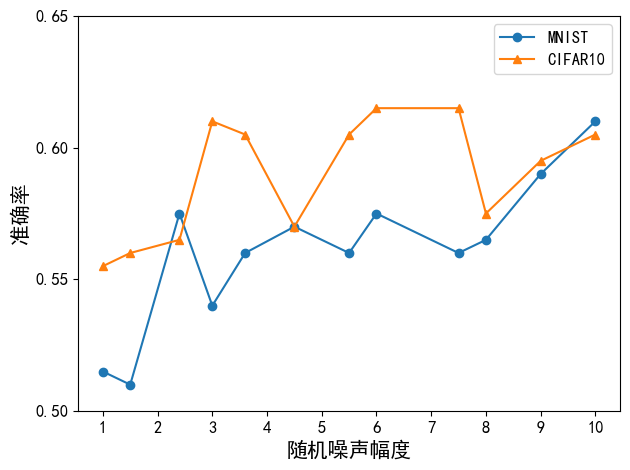

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(dpi=600)

noise_range_mnist_acc = [0.515, 0.51, 0.575, 0.54, 0.56, 0.57, 0.56, 0.575, 0.56, 0.565, 0.59, 0.61]
noise_range_cifar10_acc = [0.555, 0.56, 0.565, 0.61, 0.605, 0.57, 0.605, 0.615, 0.615, 0.575, 0.595, 0.605]
range_noise = [1, 1.5 ,2.4 ,3 ,3.6, 4.5, 5.5, 6.0, 7.5, 8, 9, 10]
fig, ax = plt.subplots()
ax.plot(range_noise, noise_range_mnist_acc, marker='o', label='MNIST')
ax.plot(range_noise, noise_range_cifar10_acc, marker='^', label='CIFAR10')
ax.legend(fontsize=12)
plt.xticks(range(1,11), fontsize=12)
plt.yticks([0.5,0.55,0.6,0.65], fontsize=12)
plt.xlabel('随机噪声幅度', fontsize=15)
plt.ylabel('准确率', fontsize=15)
# ax.grid(True, axis='y')
plt.tight_layout()
fig.show()
plt.savefig('F:/data_tear/pic/幅度.png', dpi=600)

C:\Users\hp\AppData\Local\Temp\ipykernel_2404\4268723025.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 3840x2880 with 0 Axes>

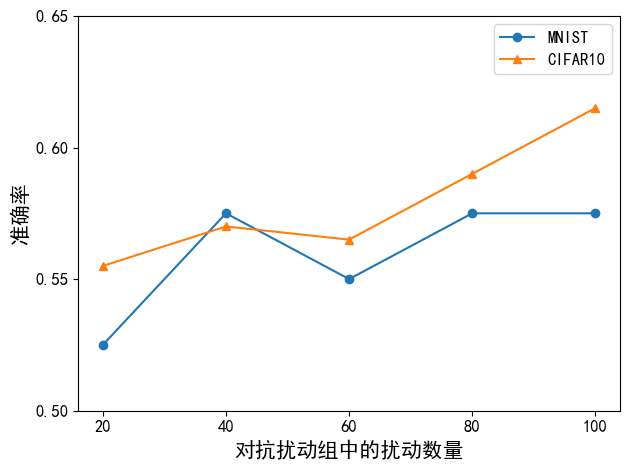

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(dpi=600)

noise_num_mnist_acc = [0.525, 0.575, 0.55, 0.575, 0.575]
noise_num_mnist_pre = [0.513, 0.545, 0.528, 0.551, 0.550]
noise_num_cifar10_acc = [0.555, 0.57, 0.565, 0.59, 0.615]
noise_num_cifar10_pre = [0.530, 0.544, 0.539, 0.554, 0.578]
noise_num = [20,40,60,80,100]
fig, ax = plt.subplots()
ax.plot(noise_num, noise_num_mnist_acc, marker='o', label='MNIST')
ax.plot(noise_num, noise_num_cifar10_acc, marker='^', label='CIFAR10')
ax.legend(fontsize=12)
plt.xticks(noise_num, fontsize=12)
plt.yticks([0.5,0.55,0.6,0.65], fontsize=12)
plt.xlabel('对抗扰动组中的扰动数量', fontsize=15)
plt.ylabel('准确率', fontsize=15)
# ax.grid(True, axis='y')
plt.tight_layout()
fig.show()
plt.savefig('F:/data_tear/pic/点数量.png', dpi=600)

C:\Users\hp\AppData\Local\Temp\ipykernel_2404\1928690859.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 3840x2880 with 0 Axes>

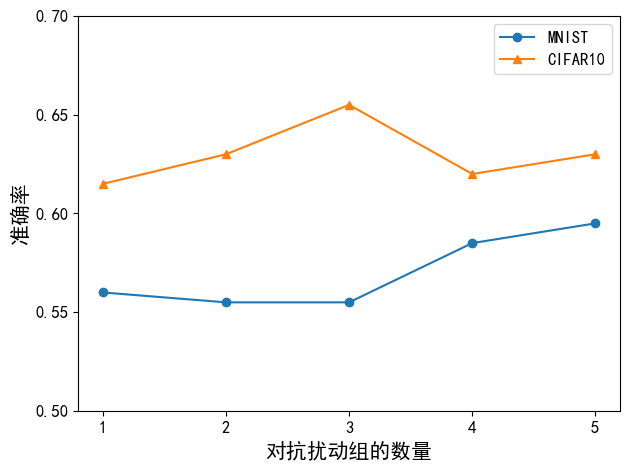

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(dpi=600)

noise_clnum_mnist_acc = [0.56, 0.555, 0.555, 0.585, 0.595]
noise_clnum_cifar10_acc = [0.615, 0.63, 0.655, 0.62, 0.63]
noise_clnum = [1,2,3,4,5]
fig, ax = plt.subplots()
ax.plot(noise_clnum, noise_clnum_mnist_acc, marker='o', label='MNIST')
ax.plot(noise_clnum, noise_clnum_cifar10_acc, marker='^', label='CIFAR10')
ax.legend(fontsize=12)
plt.xticks(noise_clnum, fontsize=12)
plt.yticks([0.5,0.55,0.6,0.65,0.7], fontsize=12)
plt.xlabel('对抗扰动组的数量', fontsize=15)
plt.ylabel('准确率', fontsize=15)
# ax.grid(True, axis='y')
plt.tight_layout()
fig.show()
plt.savefig('F:/data_tear/pic/组数量.png', dpi=600)

## 定性图

In [36]:
distances_train = torch.load('F:/data_tear/' + str(FL_params.data_name) + '/ablation/range/pro_distances1.0_mem.pth')
distances_test = torch.load('F:/data_tear/' + str(FL_params.data_name) + '/ablation/range/pro_distances1.0_nonmem.pth')
print(distances_train.shape)

torch.Size([1000, 500])


C:\Users\hp\AppData\Local\Temp\ipykernel_2404\3705603845.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()  # 显示图形


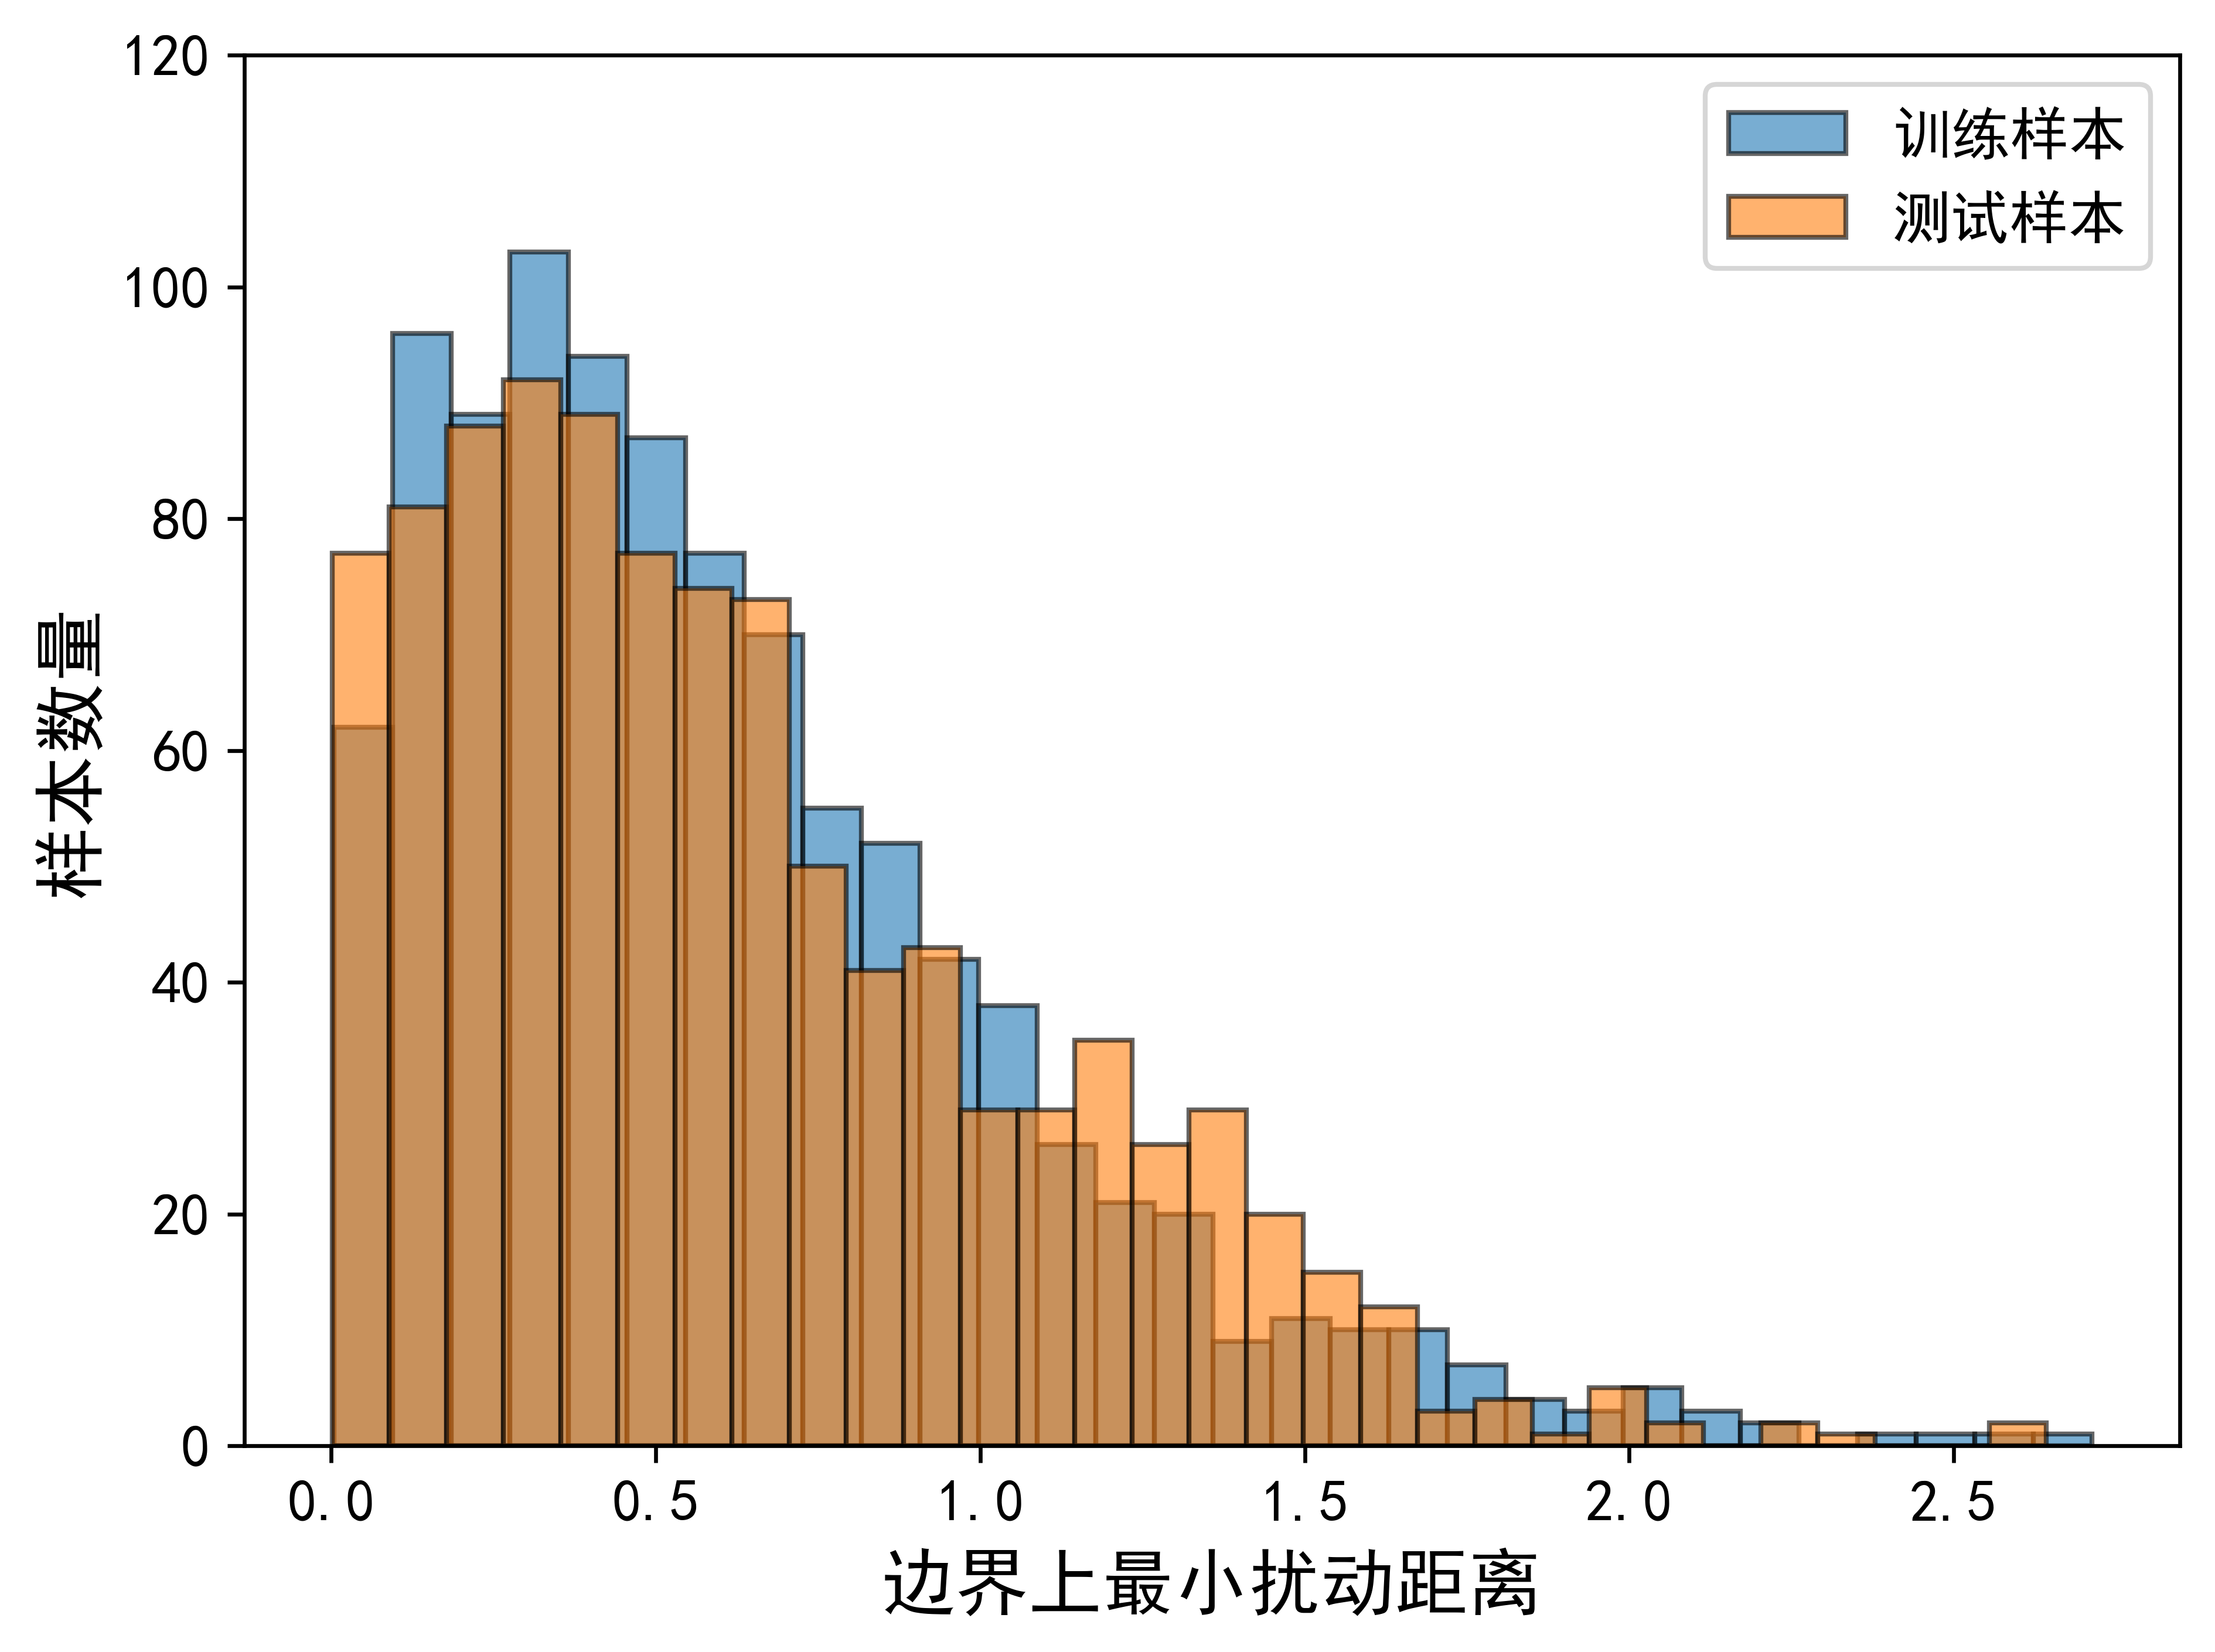

In [8]:
dataset_name = 'cifar10'
FL_params, init_GM = data_params(dataset_name)
distances_train = torch.load('F:/data_tear/pic/' + str(FL_params.data_name) + '_distrain.pth')
distances_test = torch.load('F:/data_tear/pic/' + str(FL_params.data_name) + '_distest.pth')

distance_train_bd = torch.min(distances_train, dim=1)[0]  #(samnum,)
distance_test_bd = torch.min(distances_test, dim=1)[0]  #(samnum,)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
fig = plt.figure(dpi=600)
# 绘制直方图
plt.hist(distance_train_bd.numpy(), bins=30, edgecolor='black',alpha=0.6,label='训练样本')  # 设置直方图的箱数和边界颜色
plt.hist(distance_test_bd.numpy(), bins=30, edgecolor='black',alpha=0.6,label='测试样本') 
# plt.title('Histogram of Data')
plt.xlabel('边界上最小扰动距离', fontsize = 15)
plt.ylabel('样本数量', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks([0,20,40,60,80,100,120],fontsize = 12)
plt.legend(fontsize = 12)
plt.tight_layout()
fig.show()  # 显示图形
plt.savefig('F:/data_tear/pic/data_bdattack.png', dpi=600)

tensor([  8,  39,  48,  78, 109, 170, 175, 239, 325, 346, 359, 364, 375, 407,
        451, 476, 494, 512, 515, 550, 555, 556, 579, 608, 626, 636, 639, 661,
        697, 740, 745, 787, 871, 958, 996])
tensor([ 0.0098, -0.0059, -0.0197,  0.0138,  0.0151,  0.0077,  0.0072,  0.0030,
         0.0067,  0.0113, -0.0067,  0.0191, -0.0048,  0.0055, -0.0122, -0.0103,
         0.0131, -0.0174,  0.0121,  0.0056,  0.0157, -0.0063, -0.0184,  0.0050,
         0.0101,  0.0121,  0.0036, -0.0100,  0.0052, -0.0066, -0.0009,  0.0180,
         0.0176,  0.0147,  0.0020])
torch.Size([500])
torch.Size([35, 500])
torch.Size([2, 500])


C:\Users\hp\AppData\Local\Temp\ipykernel_2404\1394387216.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


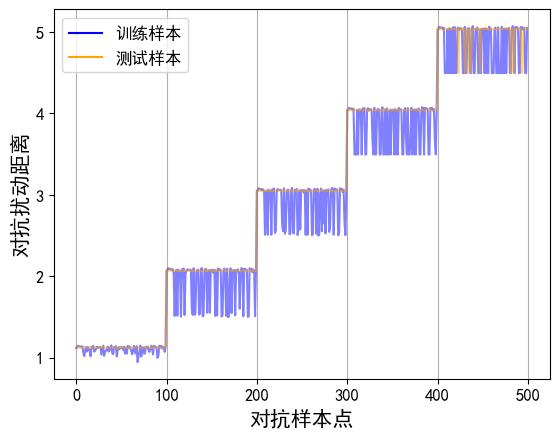

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
dataset_name = 'cifar10'
FL_params, init_GM = data_params(dataset_name)
dis_train = torch.load('F:/data_tear/' + str(FL_params.data_name) + '/ablation/range/pro_distances1.0_mem.pth')
dis_test = torch.load('F:/data_tear/' + str(FL_params.data_name) + '/ablation/range/pro_distances1.0_nonmem.pth')
distances_train = torch.load('F:/data_tear/pic/' + str(FL_params.data_name) + '_distrain.pth')
distances_test = torch.load('F:/data_tear/pic/' + str(FL_params.data_name) + '_distest.pth')
distance_train_bd = torch.min(distances_train, dim=1)[0]  #(samnum,)
distance_test_bd = torch.min(distances_test, dim=1)[0]  #(samnum,)
itd = 207
def find_min(train_dot, test_list, epsilon):
    delta = torch.abs(train_dot - test_list)
    ind = torch.nonzero(delta < epsilon, as_tuple=True)[0]
    print(ind)
    print((train_dot - test_list)[ind])
    return ind
ind = find_min(distance_train_bd[itd], distance_test_bd, 0.02)
# print(dis_test[ind][:,-100:].shape)
# dis_test_var = torch.var(dis_test[ind][:,-100:], dim=1)
# print(torch.argmax(dis_test_var))
# print(dis_test_var[6])
fig = plt.figure()
lines1 = plt.plot(torch.arange(dis_train.shape[1]), dis_train[itd:itd+1].T, color='blue', alpha=0.5)
lines2 = plt.plot(torch.arange(dis_test.shape[1]), dis_test[ind][6].T, color='orange', alpha=0.5)
# plt.title('advs_distance')
plt.xlabel('对抗样本点', fontsize=15)
plt.ylabel('对抗扰动距离', fontsize=15)
plt.xticks(range(0,dis_train.shape[1]+1,100), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x')
legend = plt.legend([lines1[0], lines2[0]], ['训练样本', '测试样本'], fontsize=12)
for line in legend.get_lines():
    line.set_alpha(1)
fig.show()

print(dis_train[itd].shape)
print(dis_test[ind].shape)
dis_array = torch.cat((dis_train[itd].unsqueeze(0), dis_test[ind][6].unsqueeze(0)), dim=0)
print(dis_array.shape)
# for idx in range(5):
#     dis_array[0, idx*100: (idx+1)*100] -= idx
#     dis_array[1, idx*100: (idx+1)*100] -= idx
# lines1 = plt.plot(torch.arange(dis_train.shape[1]), dis_array[0].T, color='blue', alpha=0.5)
# lines2 = plt.plot(torch.arange(dis_test.shape[1]), dis_array[1].T, color='orange', alpha=0.5)

1000
1000
1000


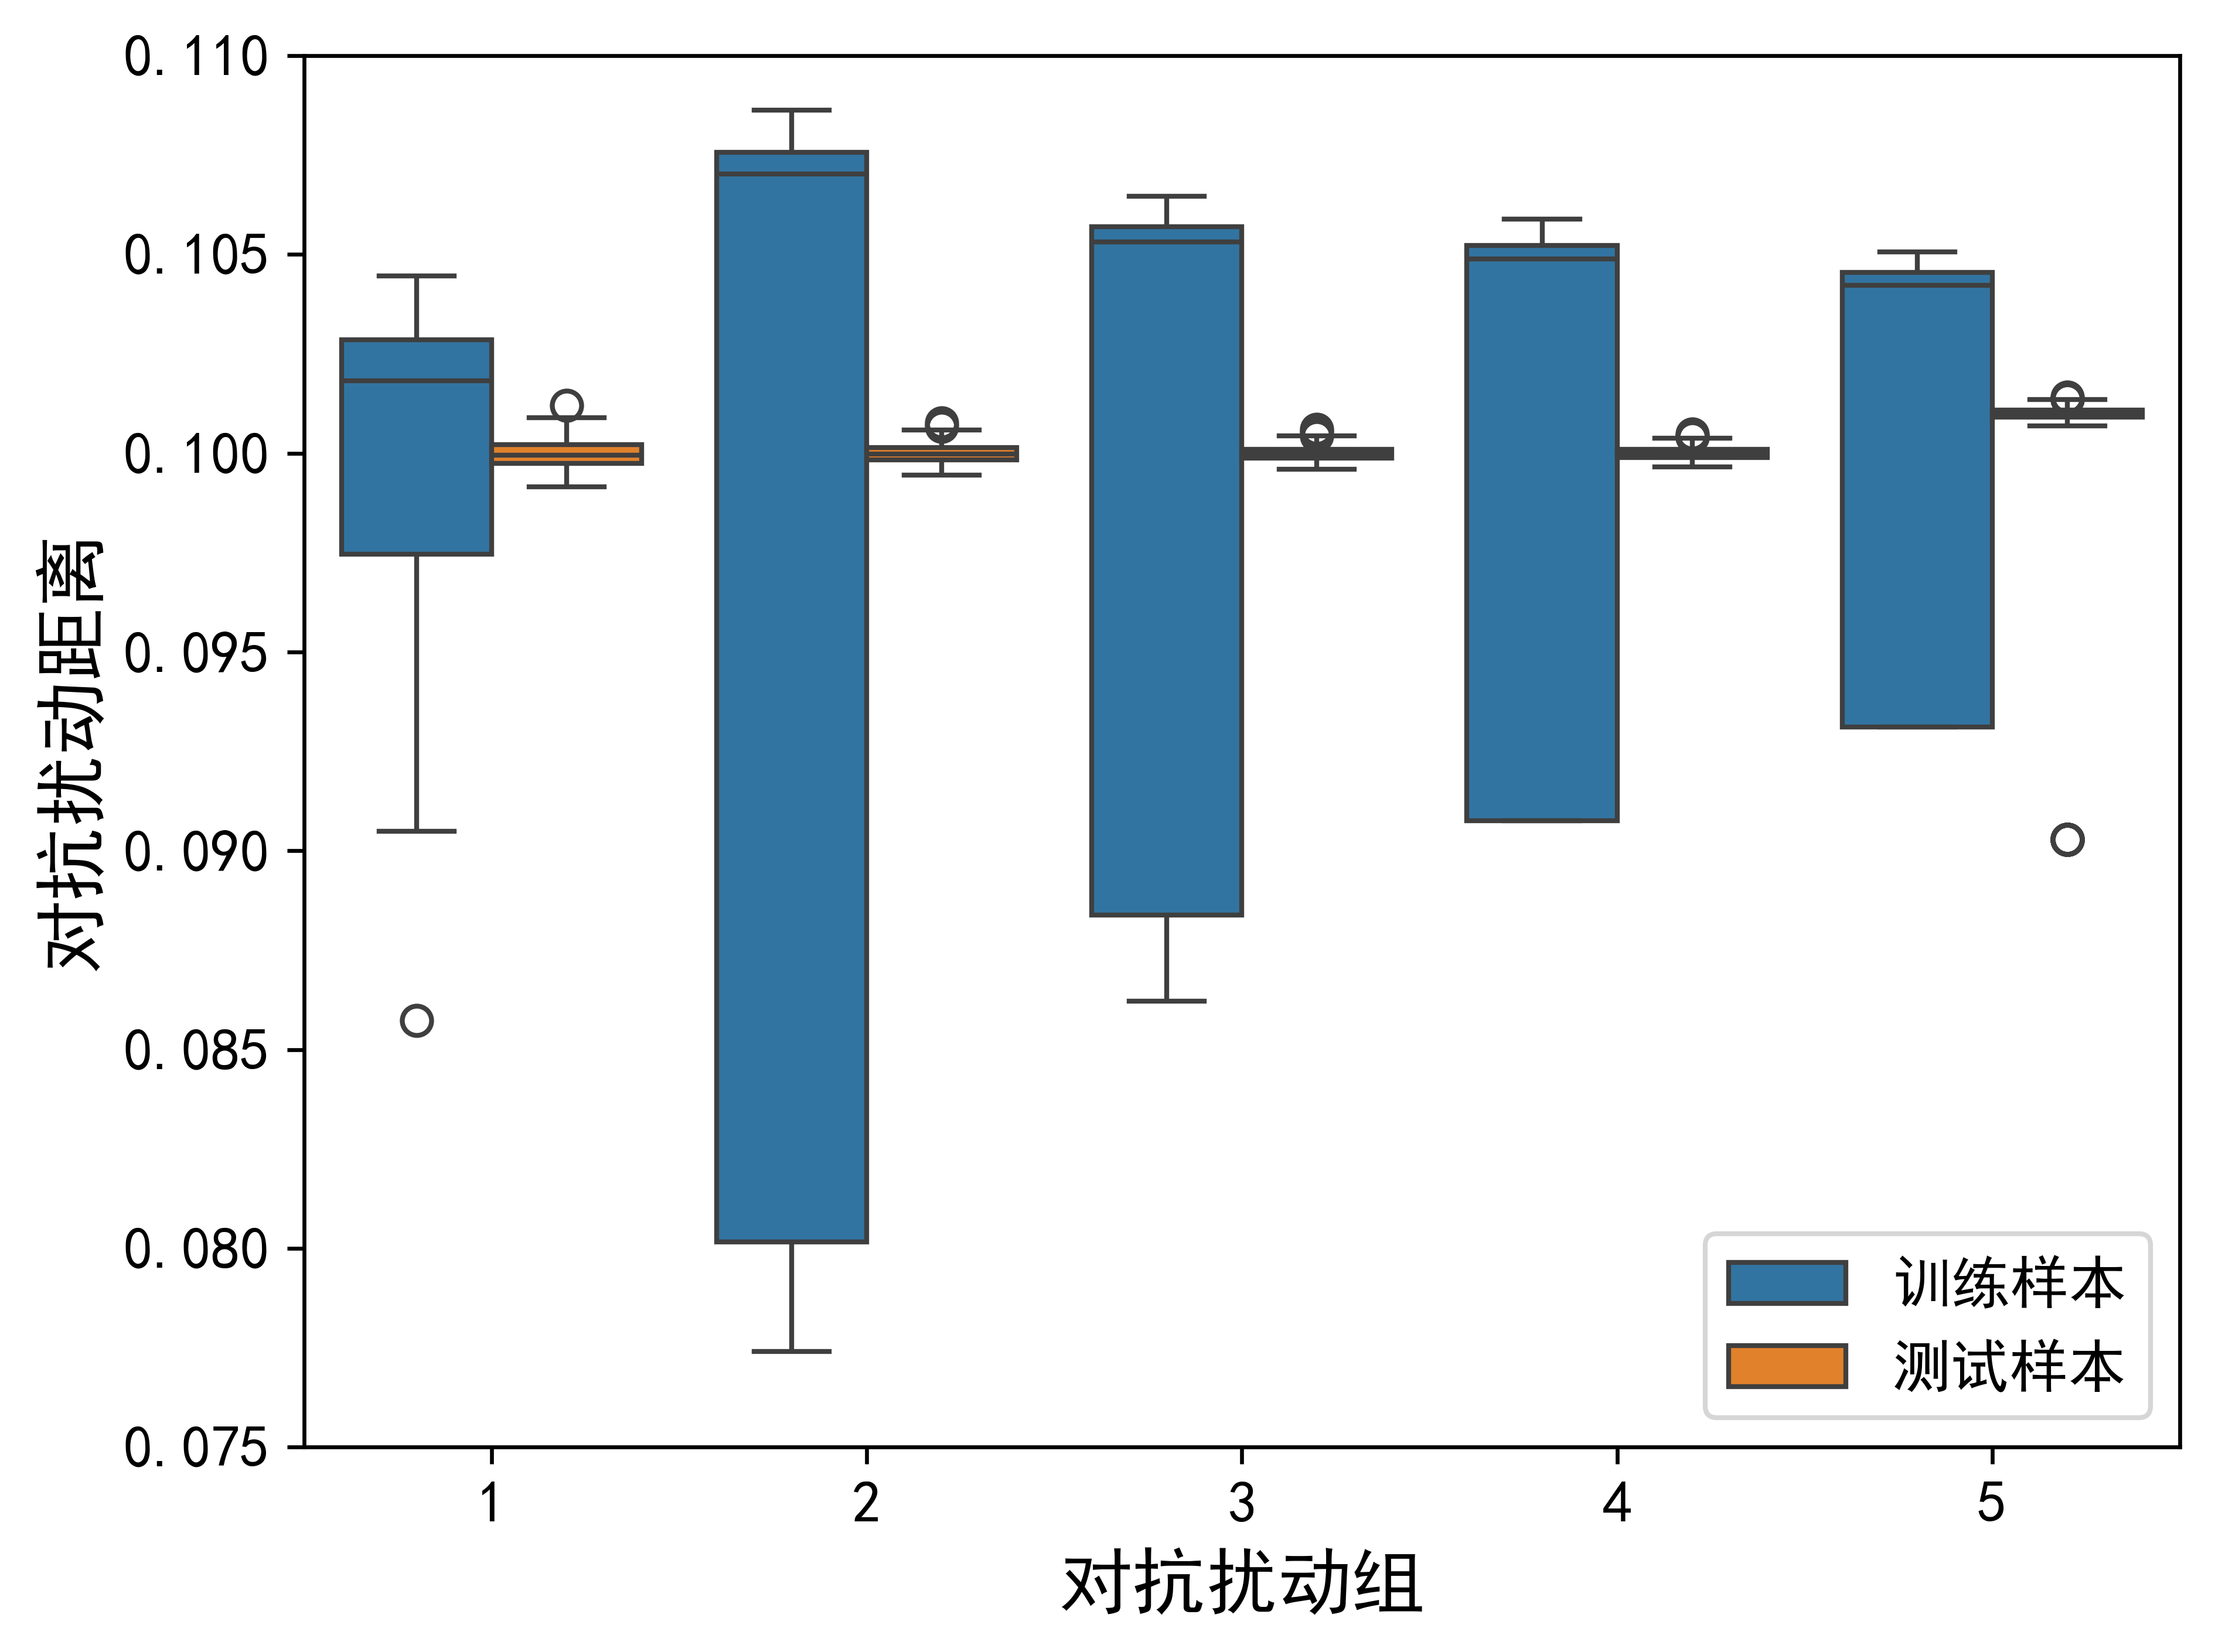

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
array_num = 5
dis_array = dis_array.reshape(2,5,100)
dis_array = dis_array[:,0:array_num,:]
dis_array = dis_array / torch.norm(dis_array, dim=2).unsqueeze(2)
dis_array = dis_array.reshape(2,-1)
data = {'样本类型':['训练样本']*dis_array.shape[1] + ['测试样本']*dis_array.shape[1],
        '对抗扰动组':[x for x in range(1,array_num+1) for _ in range(100)]*2, 
        '对抗扰动距离':dis_array.numpy().reshape(-1)}
print(len(data['样本类型']))
print(len(data['对抗扰动组']))
print(len(data['对抗扰动距离']))
data = pd.DataFrame(data)
# 设置图形大小
# plt.rcParams["figure.figsize"] = [7.00, 3.50]
# plt.rcParams["figure.autolayout"] = True
plt.figure(dpi=600)
# 导入Seaborn数据集
# data = dis_array.numpy()
# 创建分组箱线图
fig = sns.boxplot(x='对抗扰动组', y='对抗扰动距离',hue='样本类型', data=data)
handles, labels = plt.gca().get_legend_handles_labels()
# 创建一个新的图例，只包含标记但不包含名称
plt.legend(handles=handles, labels=['训练样本', '测试样本']*len(labels), fontsize=12, loc='lower right')
# tips = sns.load_dataset('tips')
# print(tips)
# sns.boxplot(x='day',y='tip',hue='sex',data=tips)
plt.xlabel('对抗扰动组', fontsize = 15)
plt.ylabel('对抗扰动距离', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks([0.075,0.080,0.085,0.090,0.095,0.100,0.105,0.110],fontsize = 12)
plt.ylim(0.075,0.110)
plt.tight_layout()
plt.show()
fig_plot = fig.get_figure()
fig_plot.savefig('F:/data_tear/pic/绪论图.png', dpi=600)


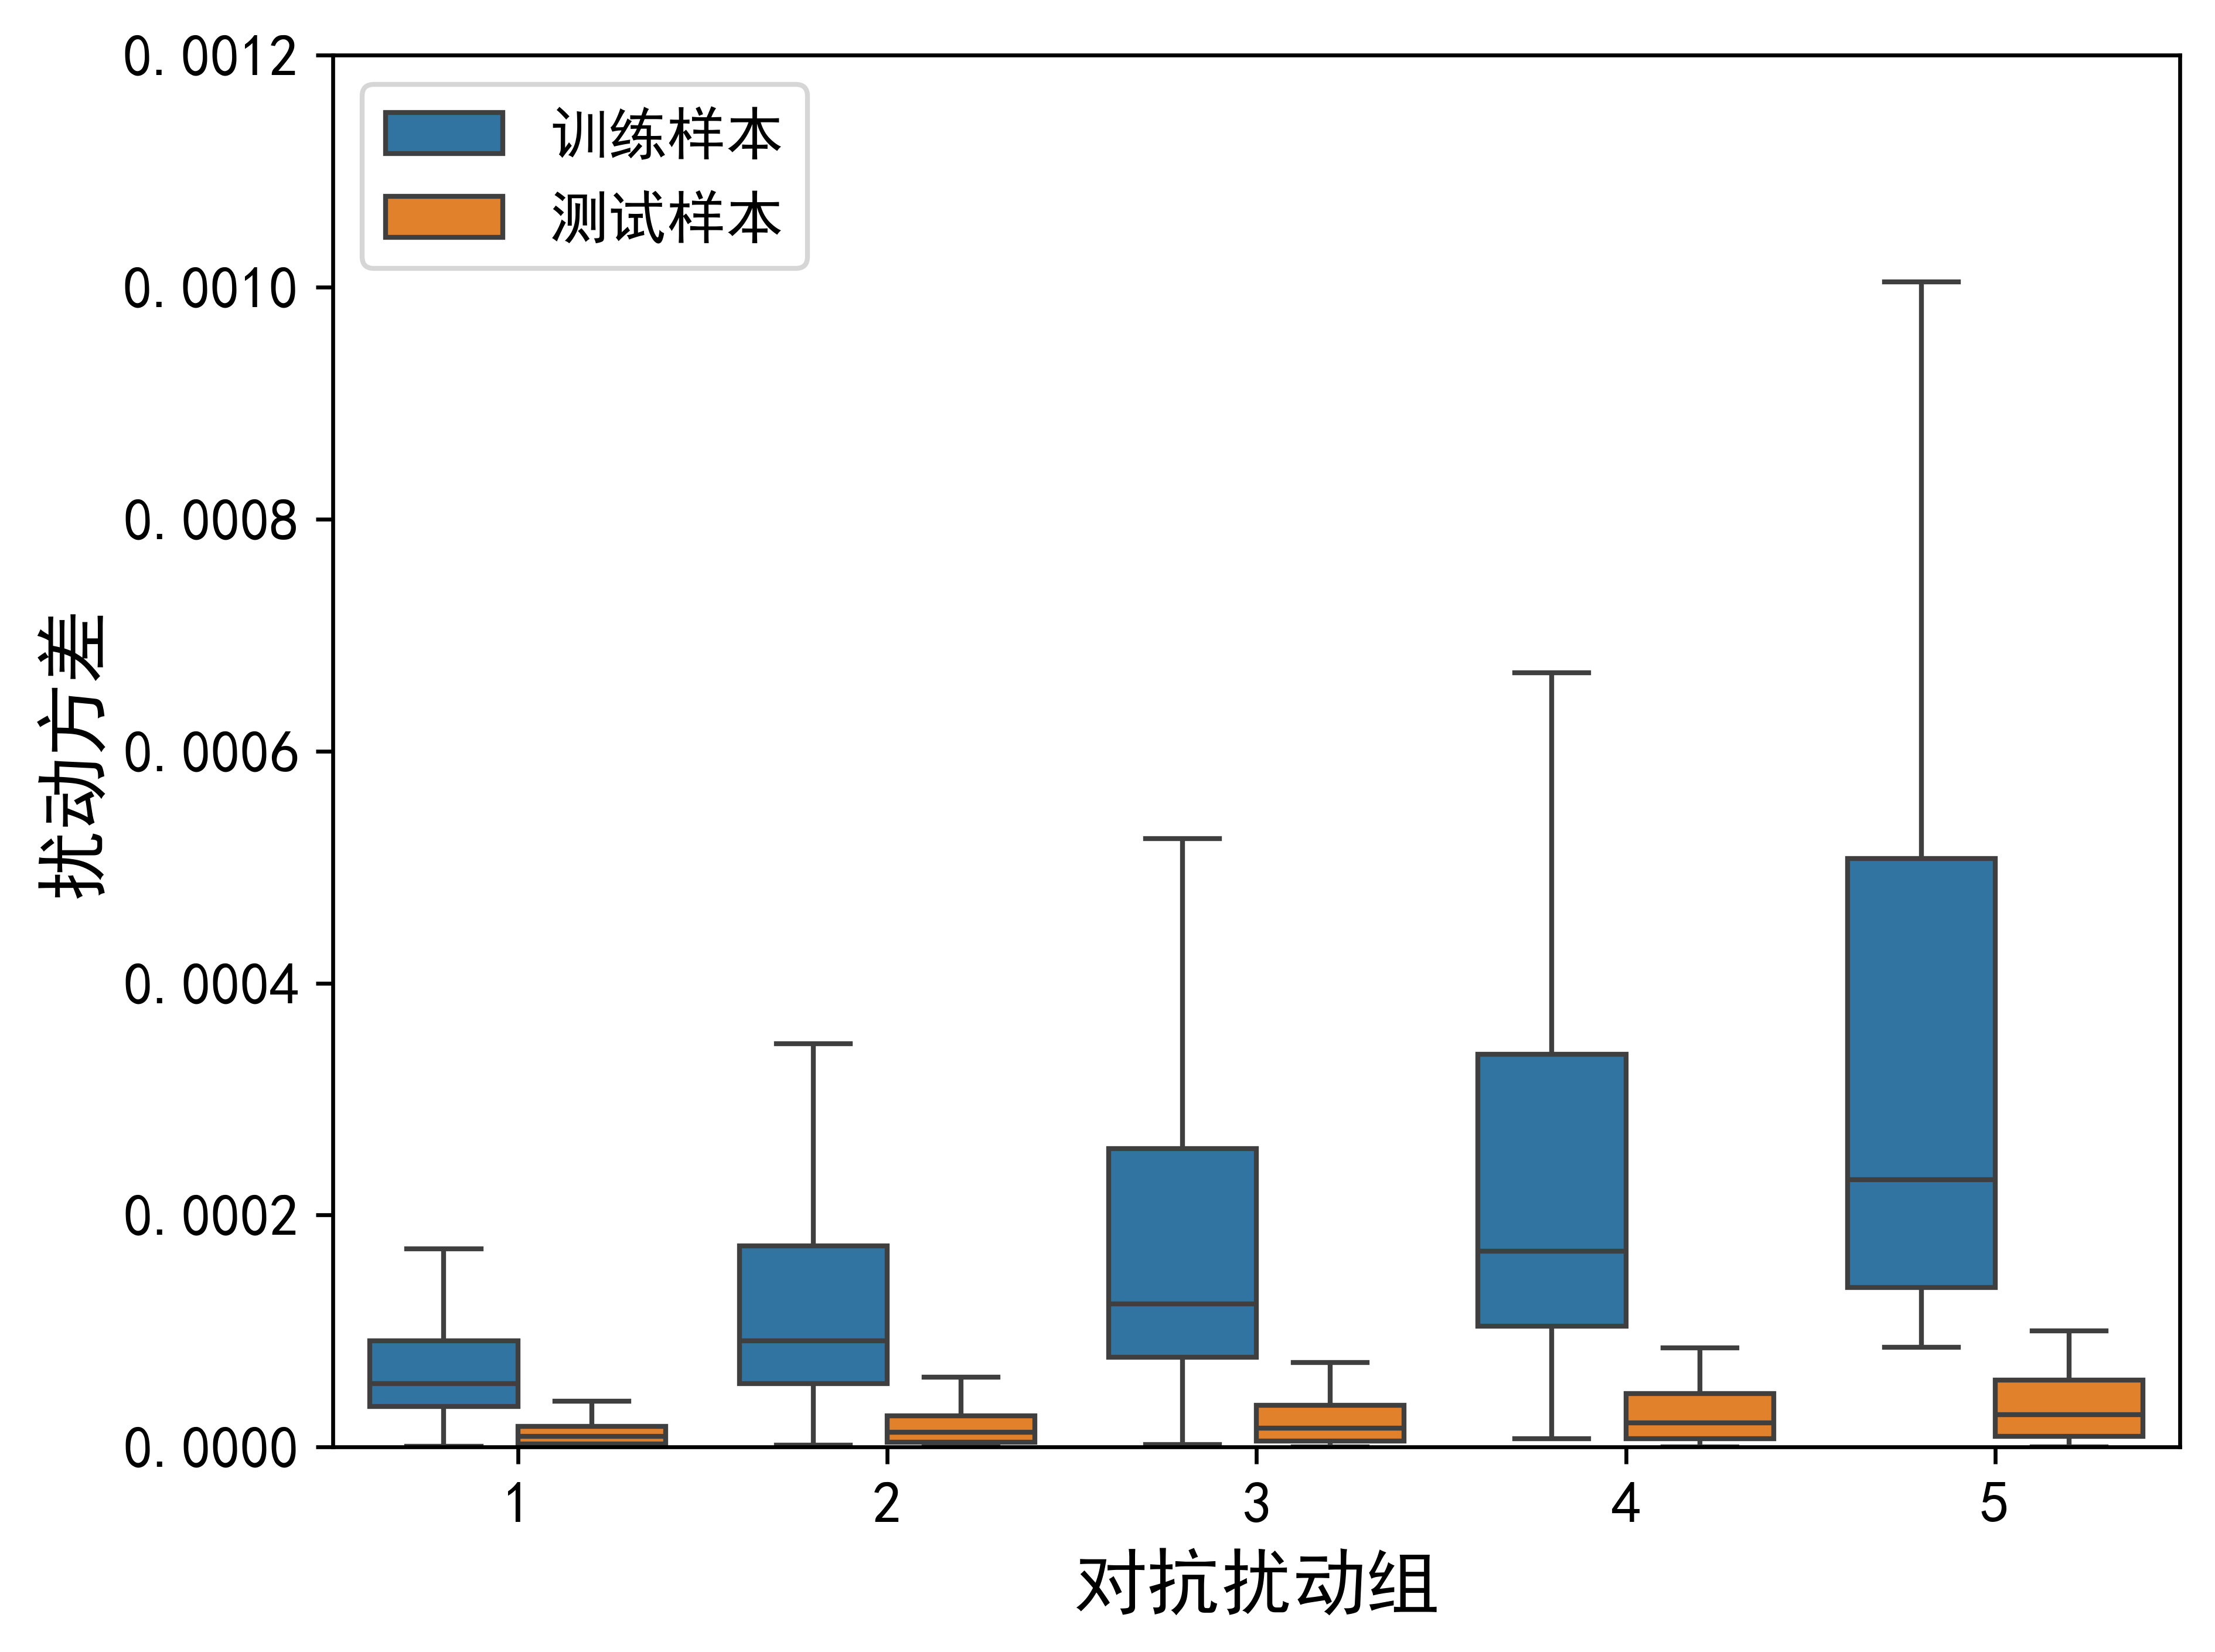

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
dataset_name = 'cifar10'
FL_params, init_GM = data_params(dataset_name)
pro_distances_mem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_distances_mem.pth')[:400]
pro_distances_nonmem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_distances_nonmem.pth')[:400]
pro_distances_mem = pro_distances_mem.reshape(pro_distances_mem.shape[0], 5, 100)
pro_distances_nonmem = pro_distances_nonmem.reshape(pro_distances_nonmem.shape[0], 5, 100)
pro_mem_var = torch.var(pro_distances_mem, dim=2)
pro_nonmem_var = torch.var(pro_distances_nonmem, dim=2)
# print(pro_mem_var)
pro_mem = torch.zeros((200, 5))
pro_nonmem = torch.zeros((200, 5))
# for idx in range(5):
#     mem_idx = torch.sort(pro_mem_var[:, idx], descending=True)[1][:200]
#     nonmem_idx = torch.sort(pro_nonmem_var[:, idx])[1][:200]
#     pro_mem[:, idx] = pro_mem_var[mem_idx, idx]
#     pro_nonmem[:, idx] = pro_nonmem_var[nonmem_idx, idx]
# print(pro_mem)
mem_idx = torch.sort(pro_mem_var[:, -1], descending=True)[1][:200]
nonmem_idx = torch.sort(pro_nonmem_var[:, -1])[1][:200]
pro_mem = pro_mem_var[mem_idx, :]
pro_nonmem = pro_nonmem_var[nonmem_idx, :]
# print(pro_mem)
data = {'label':['训练样本']*pro_mem.shape[0]*pro_mem.shape[1] + ['测试样本']*pro_mem.shape[0]*pro_mem.shape[1], 
        '对抗扰动组':[1,2,3,4,5]*400, 
        '对抗扰动距离':torch.cat((pro_mem, pro_nonmem), dim=0).numpy().reshape(-1)}
data = pd.DataFrame(data)
# 设置图形大小
plt.figure(dpi=600)
# 导入Seaborn数据集
# data = dis_array.numpy()
# 创建分组箱线图
fig = sns.boxplot(x='对抗扰动组', y='对抗扰动距离',hue='label', data=data, showfliers=False,)
# 导入Seaborn数据集
# data = dis_array.numpy()
# 创建分组箱线图
handles, labels = plt.gca().get_legend_handles_labels()
# 创建一个新的图例，只包含标记但不包含名称
plt.legend(handles=handles, labels=['训练样本', '测试样本']*len(labels), fontsize=12, loc='upper left')
# tips = sns.load_dataset('tips')
# print(tips)
# sns.boxplot(x='day',y='tip',hue='sex',data=tips)
plt.xlabel('对抗扰动组', fontsize = 15)
plt.ylabel('扰动方差', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks([0,0.0002,0.0004,0.0006,0.0008,0.001,0.0012],fontsize = 12)
plt.ylim(0,0.0012)
# plt.rcParams['font.family'] = 'Arial'
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.show()
fig_plot = fig.get_figure()
fig_plot.savefig('F:/data_tear/pic/cifar10_var.png', dpi=600)
# tips = sns.load_dataset('tips')
# print(tips)
# sns.boxplot(x='day',y='tip',hue='sex',data=tips)

plt.show()

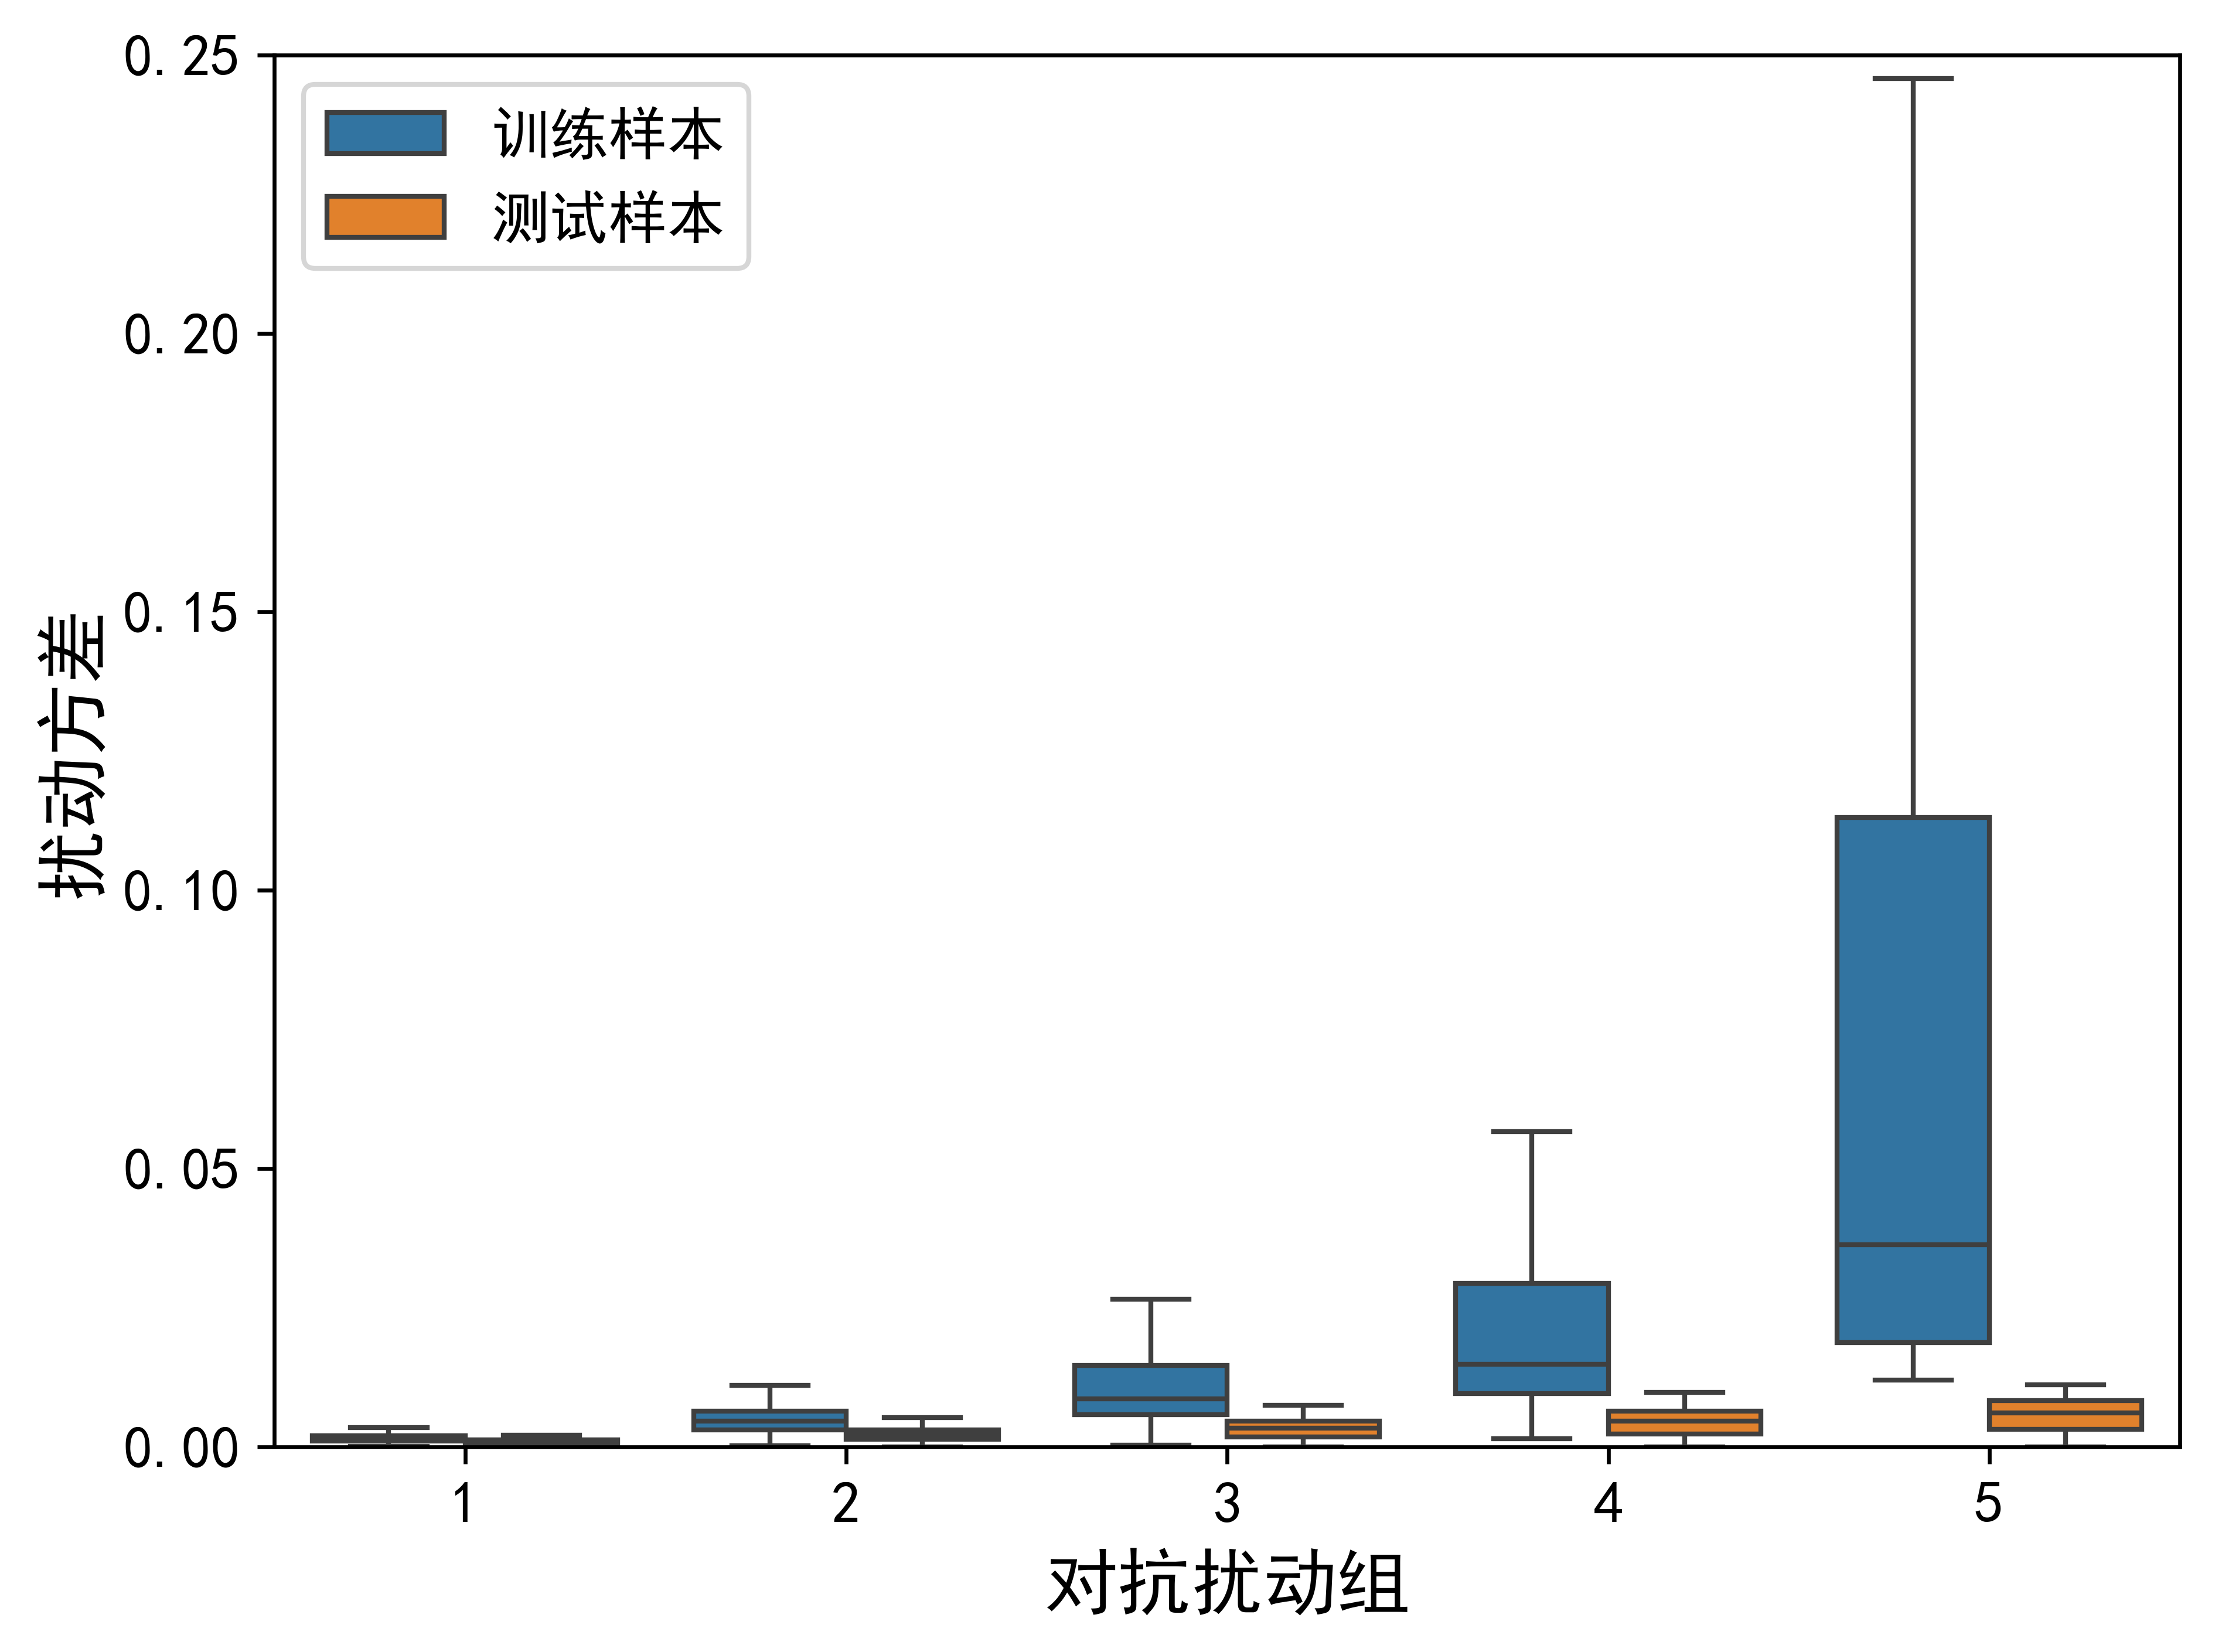

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
dataset_name = 'mnist'
FL_params, init_GM = data_params(dataset_name)
pro_distances_mem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_distances_mem.pth')[:400]
pro_distances_nonmem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_distances_nonmem.pth')[:400]
pro_distances_mem = pro_distances_mem.reshape(pro_distances_mem.shape[0], 5, 100)
pro_distances_nonmem = pro_distances_nonmem.reshape(pro_distances_nonmem.shape[0], 5, 100)
pro_mem_var = torch.var(pro_distances_mem, dim=2)
pro_nonmem_var = torch.var(pro_distances_nonmem, dim=2)
# print(pro_mem_var)
pro_mem = torch.zeros((200, 5))
pro_nonmem = torch.zeros((200, 5))
# for idx in range(5):
#     mem_idx = torch.sort(pro_mem_var[:, idx], descending=True)[1][:200]
#     nonmem_idx = torch.sort(pro_nonmem_var[:, idx])[1][:200]
#     pro_mem[:, idx] = pro_mem_var[mem_idx, idx]
#     pro_nonmem[:, idx] = pro_nonmem_var[nonmem_idx, idx]
# print(pro_mem)
mem_idx = torch.sort(pro_mem_var[:, -1], descending=True)[1][:200]
nonmem_idx = torch.sort(pro_nonmem_var[:, -1])[1][:200]
pro_mem = pro_mem_var[mem_idx, :]
pro_nonmem = pro_nonmem_var[nonmem_idx, :]
# print(pro_mem)
data = {'label':['训练样本']*pro_mem.shape[0]*pro_mem.shape[1] + ['测试样本']*pro_mem.shape[0]*pro_mem.shape[1], 
        'x':[1,2,3,4,5]*400, 
        'y':torch.cat((pro_mem, pro_nonmem), dim=0).numpy().reshape(-1)}
# print(len(data['label']))
# print(len(data['x']))
# print(len(data['y']))
data = pd.DataFrame(data)
# 设置图形大小
# plt.rcParams["figure.figsize"] = [7.00, 3.50]
# plt.rcParams["figure.autolayout"] = True
plt.figure(dpi=600)
# 导入Seaborn数据集
# data = dis_array.numpy()
# 创建分组箱线图
fig = sns.boxplot(x='x', y='y',hue='label', data=data, showfliers=False,)
# tips = sns.load_dataset('tips')
# print(tips)
# sns.boxplot(x='day',y='tip',hue='sex',data=tips)
# 导入Seaborn数据集
# data = dis_array.numpy()
# 创建分组箱线图
# fig = sns.boxplot(x='对抗扰动组', y='对抗扰动距离',hue='label', data=data, showfliers=False,)
# 导入Seaborn数据集
# data = dis_array.numpy()
# 创建分组箱线图
handles, labels = plt.gca().get_legend_handles_labels()
# 创建一个新的图例，只包含标记但不包含名称
plt.legend(handles=handles, labels=['训练样本', '测试样本']*len(labels), fontsize=12)
# tips = sns.load_dataset('tips')
# print(tips)
# sns.boxplot(x='day',y='tip',hue='sex',data=tips)
plt.xlabel('对抗扰动组', fontsize = 15)
plt.ylabel('扰动方差', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(0,0.25)
# plt.rcParams['font.family'] = 'Arial'
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.show()
fig_plot = fig.get_figure()
fig_plot.savefig('F:/data_tear/pic/mnist_var.png', dpi=600)

C:\Users\hp\AppData\Local\Temp\ipykernel_5596\4052793864.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


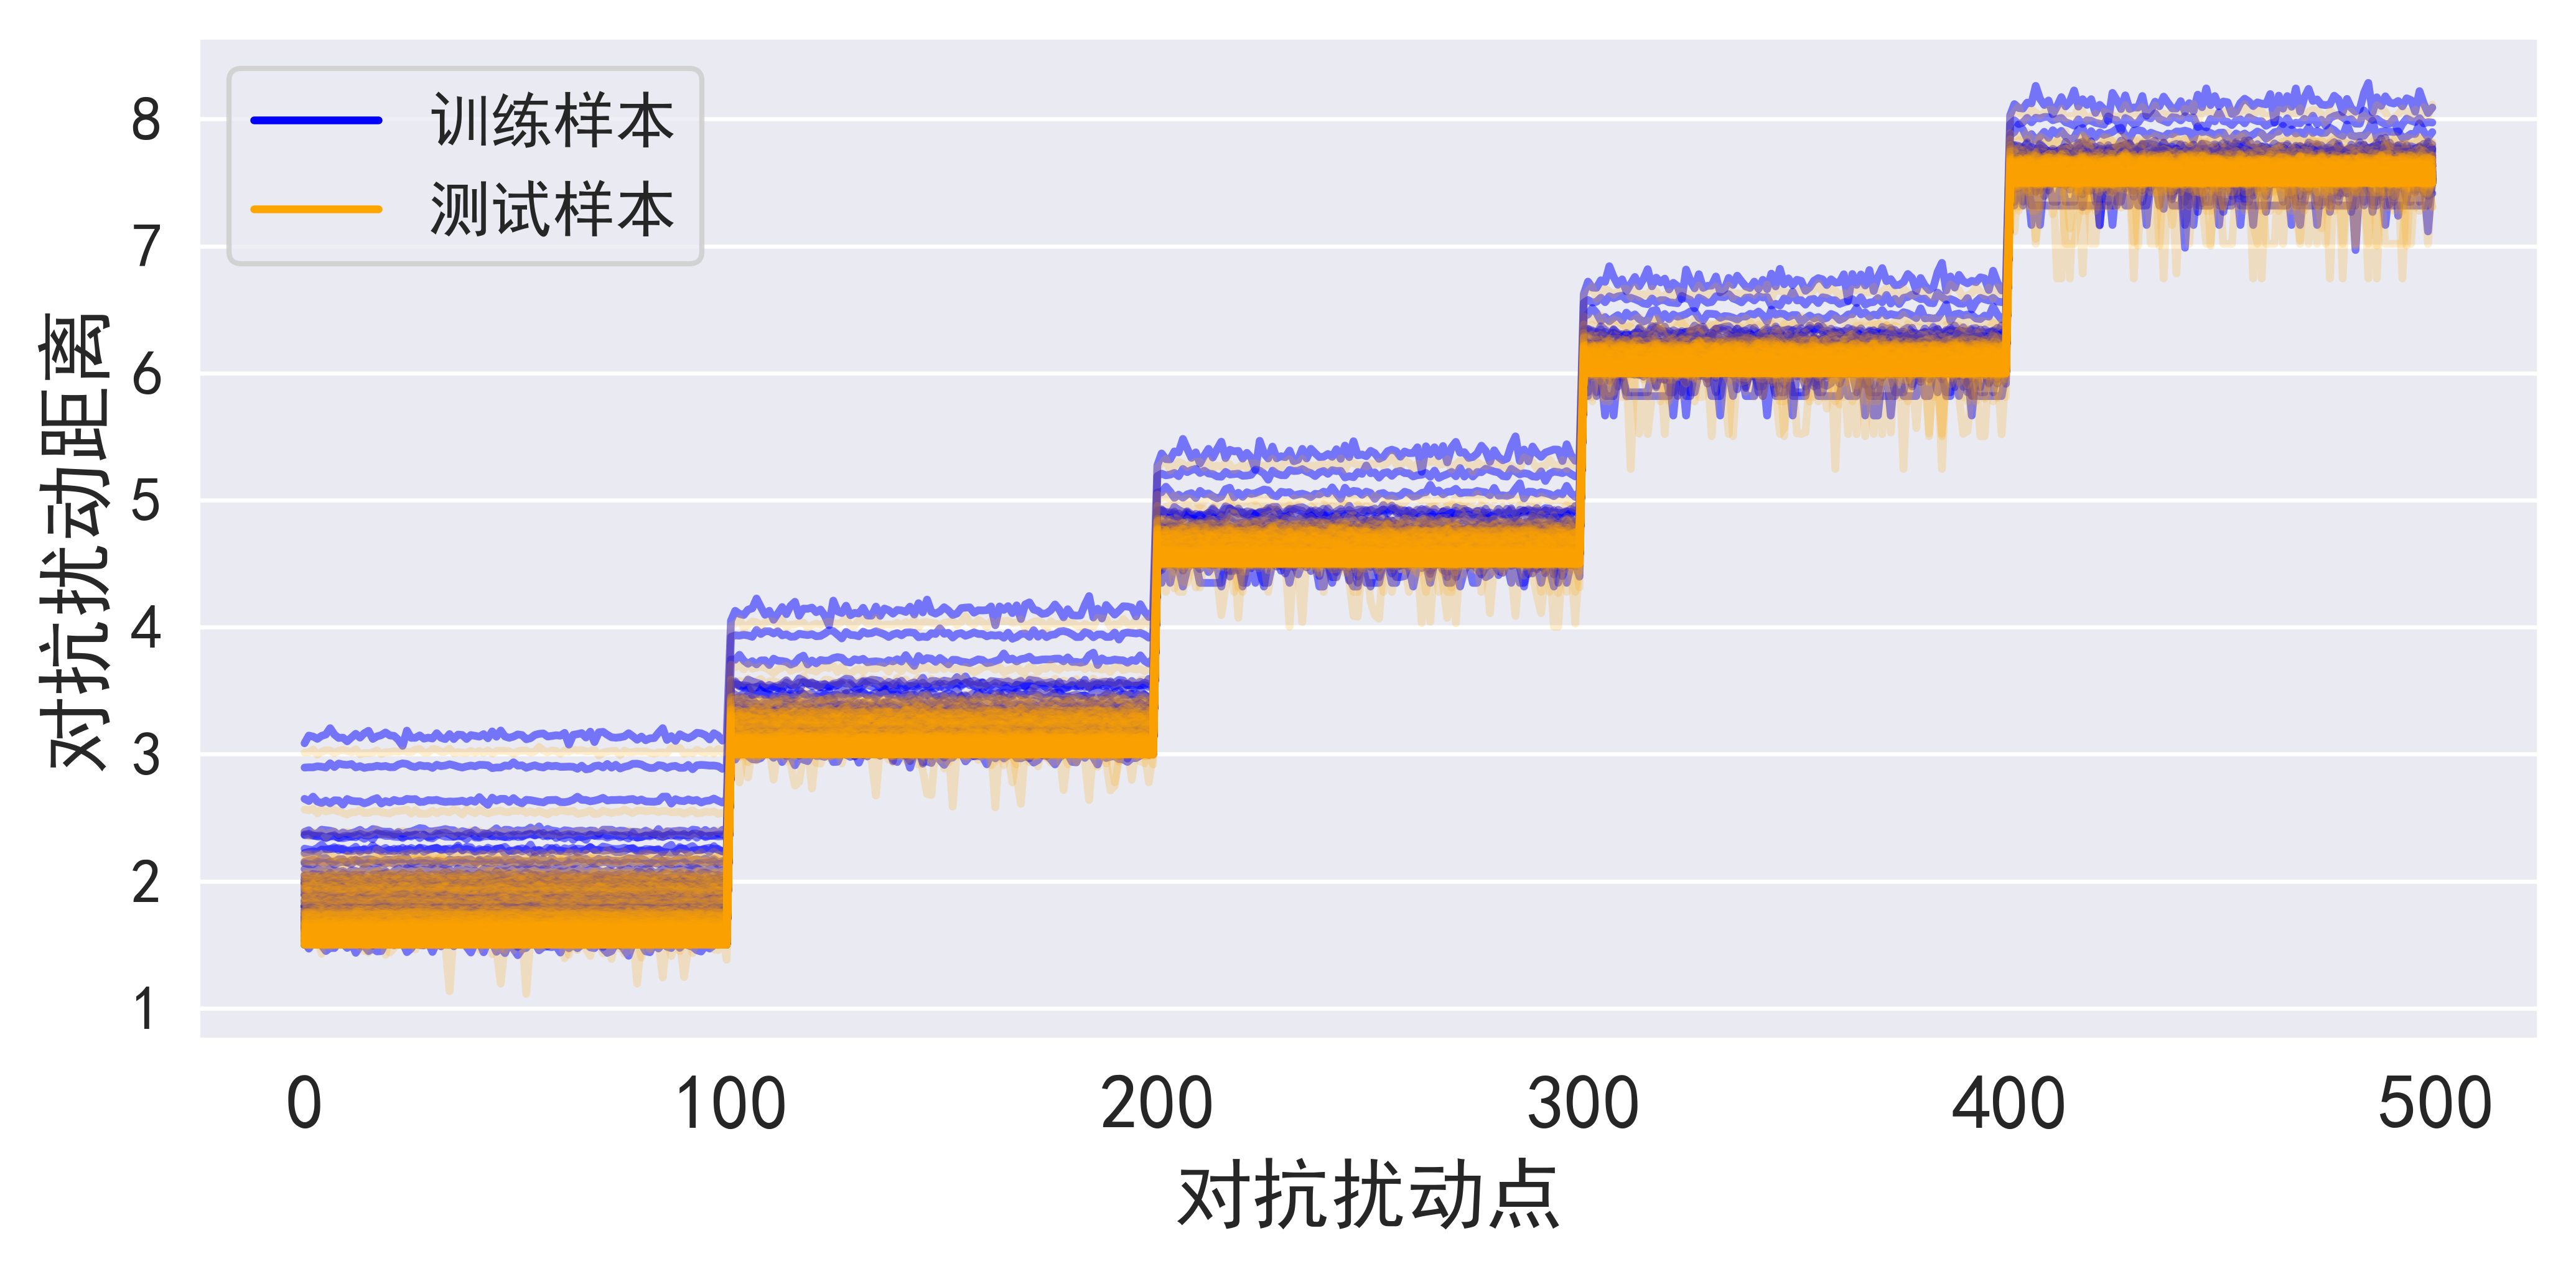

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
dataset_name = 'cifar10'
FL_params, init_GM = data_params(dataset_name)
pro_distances_mem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_distances_mem.pth')[:200]
pro_distances_nonmem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_distances_nonmem.pth')[:200]
plt.figure(dpi=600)
lines1 = plt.plot(torch.arange(pro_distances_mem.shape[1]), pro_distances_mem.T, color='blue', alpha=0.5)
lines2 = plt.plot(torch.arange(pro_distances_nonmem.shape[1]), pro_distances_nonmem.T, color='orange', alpha=0.2)
# plt.title('advs_distance')
plt.xlabel('对抗扰动点', fontsize=15)
plt.ylabel('对抗扰动距离', fontsize=15)
plt.xticks(range(0,pro_distances_mem.shape[1]+1,100), fontsize=15)
plt.yticks(fontsize=12)
plt.grid(axis='x')
legend = plt.legend([lines1[0], lines2[0]], ['训练样本', '测试样本'], fontsize=12)
for line in legend.get_lines():
    line.set_alpha(1)
fig.show()
plt.savefig('F:/data_tear/pic/cifar10_trajectory.png', dpi=600)